# Skin cancer detection with Convolutional Neural Networks

Student name: Maria Kuzmin
<br>Student pace: Flex
<br>Scheduled project review date/time: Wednesday, May 17th 1PM
<br>Instructor name: Morgan Jones

Skin cancer is by far the most common type of cancer.
<br>We want to build an app that analyzes pictures of skin anomalies to determine whether or not a skin anomaly is cancerous, to help healthcare providers make a diagnosis. 
<br>This app would be advantageous for doctors since their diagnosis will not only be based on their visual inspection of the skin but also supported by a powerful Neural Network model that compares the picture of a patient’s lesion with thousands (and potentially millions) of other ones, stored in a constantly growing database.
<br>The accuracy that we were able to achieve in building the core engine of the app (our CNN model) is between 70% and 80% for our 9 classes classification model.
<br>The recall rate that we obtained was about 85% in our binary classification model.

## Business Problem
According to one estimate, about 5.4 million cases of skin cancer are diagnosed among 3.3 million people each year (many people are diagnosed with more than one spot of skin cancer at the same time).
<br>The number of skin cancer cases among people older than 50 has been increasing for many years. This is probably from a combination of better skin cancer detection, people getting more exposure to the sun, and people living longer. 
<br>1 out of 5 Americans will develop skin cancer by the time they are 70. 
<br>Skin cancers can look quite different from one person to another due to skin tone, size and type of skin cancer and location on the body.

Causes: Skin cancer occurs when errors (mutations) occur in the DNA of skin cells. The mutations cause the cells to grow out of control and form a mass of cancer cells.
<br>Risk factors: Fair skin, light hair, freckling, moles, history of sunburns, excessive sun exposure, sunny or high-altitude climates, precancerous skin lesions, weakened immune system, etc. 
<br>If you have skin cancer, it is important to know which type you have because it affects your treatment options and your outlook (prognosis). 
<br>If you aren’t sure which type of skin cancer you have, it is recommended that you ask your doctor so you are properly aware. 
<br>A doctor will usually do an examination looking at all the skin moles, growths and abnormalities to understand which ones are at risk for being cancerous.
<br>But what if the doctor is not sure?
<br>What if we could develop a tool that could help the doctor decide with more confidence and ensure more safety for every patient?
<br>What if, to make a decision about a patient, the doctor could have the support of advanced technology and a model that makes its determination based on a direct comparison with thousands of other cases?
<br>This is what we are trying to achieve in this project.

When the model is ready to be used in the field, we could develop a cell phone app. 
<br>This app would use the cell phone camera and it would return the type of skin anomaly and the percentage probability of it being cancerous. 
<br>The app would also allow the user to upload the images to a database so the model would continue to improve in accuracy over time.
<br>The app also gives the chance to the healthcare provider to see what parts of the image the model used to decide which class the skin anomaly belongs to and to visualize the image under the different filters used to make the determination. 

Sources:
<br>[Cancer.org/skin-cancer](https://www.cancer.org/cancer/skin-cancer.html)
<br>[Cancer.org/skin-cancer-statistics](https://www.cancer.org/cancer/melanoma-skin-cancer/about/key-statistics.html)
<br>[Skincancer.org](https://www.skincancer.org/skin-cancer-information/)
<br>[MayoClinic/Skin-cancer](https://www.mayoclinic.org/diseases-conditions/skin-cancer/symptoms-causes/syc-20377605#:~:text=Skin%20cancer%20%E2%80%94%20the%20abnormal%20growth,squamous%20cell%20carcinoma%20and%20melanoma.)

## Business Stakeholder
The American Academy of Dermatologists ([website](https://www.aad.org/)) offers free skin cancer screenings all over the United States.
<br>We feel they could strongly benefit from our app by supporting their doctors whenever they need to determine the nature of any skin lesions they are examining.
<br>The app does not only return a determination of ‘benign’ or ‘malignant’ but it provides also the certainty with which the determination was made.
<br>It allows the doctor to set a ‘threshold’ over which the image is determined to be at risk for cancer (the default would be 50% but it can be lowered to catch more cases at risk). <br>The app will also show which part of the images the model focuses on to make its determination and show filters that the model applied to the image. <br>In this way, since the granularity that a computer can scan is higher than the one of the human eye, the model might have catch details that the doctor did not, and thus make a more informed assessment.
<br>The app cannot substitute the critical judgment of a human being, but by the power that this technology offers, we feel this could be a very useful tool to support a doctor in his decision.

## Summary:

Our data consisted of pictures taken of skin anomalies, with a total of 2357 images, that belong to 9 different classes of skin disorders. This seemed like a reasonable amount of data to train and test the model on. To maximize the performance, we loaded all the images instead of selecting a smaller batch. 
<br>The full resolution of the images is 256x256 pixels, but they were mostly reduced to 64x64 pixels for reasons of computational time.
<br>The goal of the project was to build a model that could classify the images, first in their 9 native classes, and secondly another model was built that would classify the images between cancerous and benign.

The Data preparation consisted in loading the images from their directory, from the original division into 9 subfolders, and later creating new directories for the binary classification, and copying the images in those directories.
<br>During the loading phase also the size of the images to import and the batch size had to be set.
<br>The data was already divided into test and train set.

The packages used were: numpy to be able to work on our images, converted into arrays, matrices and tensors. <br>Pandas to work with DataFrames especially to analyze the data and store our results. <br>Sys, os and shutil to be able to work on the directories of the images. <br>Keras for importing the images, and transforming them into arrays and preview them.
<br>Matplotlib and seaborn - to visualize and preview the data and the results of our models.
<br>Scikitlearn for model selection and for metrics to evaluate the model.

Our models are all Convolution Neural Networks. We used Tensorflow with Keras backend, for building the models.
<br>We built sequential models with densely connected layers, and took advantage of regularizers and constraints to tune the models.
<br>Moreover to tune the models we ran some GridSearchCVs utilizing wrappers from scikeras, to select the best performing number of epochs and batch size, optimization algorithm, neuron activation function and number of neurons. Also L2 regularization and dropout regularization were a part of the tuning process.
<br>For validation, a cross validation was ran at every fitting of the model, setting aside a 20% validation set.
<br>During the grid searches, a 3-fold cross validation was used.
<br>Finally LIME and Visualization of Activation Layers were used for model explainability, and scikit image was also used to view the images produced by LIME.

In terms of metrics: for the 9 classes model we used accuracy and loss to evaluate our models.
<br>For the binary classification instead we focused on recall, as often happens in the medical field, to try and minimize the cases of False Negatives. We also used f1 score and accuracy to keep track of the overall performance of the model.

The best 9 classes model reached a mean accuracy (calculated over 10 samples) between 70% and 80% and a loss between 0 and 2 on the train.
<br>When evaluated on the holdout test set the results were an average accuracy between 15% and 20% on the test and loss on the test between 6 and 14.
<br>The binary classification model had a mean Recall of 80% and f1 of 85% on the train. 
<br>On the test we obtained a recall around 65% and f1 around 70%. Both with a recall threshold of 50%.
<br>When we moved the recall threshold to 30% the model reached on the test a recall of about 70%.

## Roadmap
Here is a roadmap of the steps that we are going to take:

* [The Data:](#Data)
    * Data Understanding
    * Benign Classes
    * Malignant Classes
    * Data Preparation
	* Importing images
	* Building Functions
* [9 classes Model](#9clas)
    * Naive Model
    * Improving model with 9 classes:
		* Normalize Data
		* Adding more layers and higher resolution
		* Grid Search Batch Size and Epochs
		* Grid Search optimization Algorithm
		* Grid Search Learning Rate
		* Grid Search Neuron Activation Function
		* Grid Search Number of Neurons
		* Tuning:
			* Regularization
			* Dropout
	* Best model
	* Evaluate the model
* [Changing to two classes](#2classes)
	* New Metrics
	* Binary Models:
		* Naive Model
		* Grid Search Batch Size and Epochs
		* Grid Search optimization Algorithm
		* Grid Search Learning Rate and Momentum
		* Grid Search Neuron Activation Function
		* Grid Search Number of Neurons
		* Tuning:
			* Regularization
			* Dropout
	* Best model
	* Evaluate the model
	* Increasing recall threshold
* [LIME ](#LIME)
* [Visualizing activation layers](#VAL)
* [Results](#Resu)
* [Limitations](#Lim)
* [Recommendations](#Rec)
* [Next Steps](#Next)

## The Data  <a id='Data'></a>
The dataset was taken from Kaggle at the following link:
[Skin Cancer ISIC](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic).
<br>This set consists of 2357 images of malignant and benign oncological diseases, which
were formed from The International Skin Imaging Collaboration (ISIC).
<br>The raw data comes from the [ISIC Archive](https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main).
<br>The data contains images of skin anomalies that belong to 9 different classes.
<br>All images were sorted according to the classification taken with ISIC.

The data is stored in folders, already divided between train and test.
<br>The train contains 2239 images and the test contains 118 images. The images are in the
jpg format.
<br>The size of the images is 256x256 pixels, and the size of the whole file is 2GB.
<br>The only two variables are the pictures and their labels, which identify the type of skin
anomaly. 
<br>The different classes are:
- actinic keratosis
- basal cell carcinoma
- dermatofibroma
- melanoma
- nevus
- pigmented benign keratosis
- seborrheic keratosis
- squamous cell carcinoma
- vascular lesion

We will explore later the distribution of the data in the different classes, between train and test.
Now let us proceed with some imports and then we will load the data.

In [1]:
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from lime import lime_image
from skimage.segmentation import mark_boundaries

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

Loading the images form the two different folders, train and test,  in which they are divided in subfolders of the 9 different classes.

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/train (2239 images)
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Get all the data in the directory data/test (118 images)
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Create the datasets
train_images_fs, train_labels = next(train_generator)
test_images_fs, test_labels = next(test_generator)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


### Data Understanding:
Let us dig deeper into what each one of these classes are, and we will preview one image for each class to get a visual sense of what our model is going to be studying.

Later we will divide the classes in two macro classes, benign and malignant, since we will also build a model to determine if the image is ultimately of benign or cancerous nature.

### Benign Classes:

**Dermatofibroma**
<br>Dermatofibroma is a commonly occurring cutaneous entity usually centered within the skin's dermis. Dermatofibromas are referred to as benign fibrous histiocytomas of the skin, superficial/cutaneous benign fibrous histiocytomas, or common fibrous histiocytoma. 
<br>These mesenchymal cell lesions of the dermis clinically are firm subcutaneous nodules that occur on the extremities in the vast majority of cases and may or may not be associated with overlying skin changes. 
<br>They are most commonly asymptomatic and usually relatively small, less than or equal to 1 centimeter in diameter.
Let us preview a picture of it:

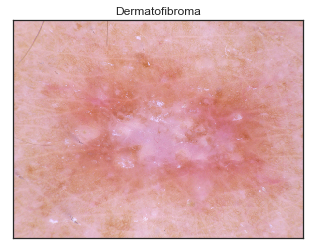

In [3]:
img = mpimg.imread('dataskin/Train/dermatofibroma/ISIC_0025223.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Dermatofibroma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Pigmented benign keratosis and Seborrheic keratosis**
<br>They are both benign keratosis, in fact most of the times they are classified together.
A seborrheic keratosis is a common noncancerous (benign) skin growth. People tend to get more of them as they get older.

Seborrheic keratoses are usually brown, black or light tan. The growths (lesions) look waxy or scaly and slightly raised. They appear gradually, usually on the face, neck, chest or back.
Seborrheic keratoses are harmless and not contagious. 

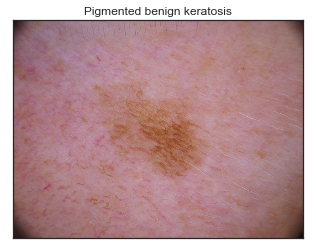

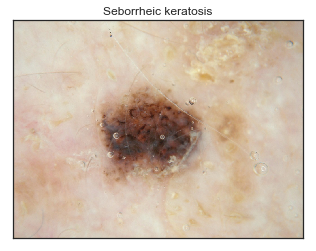

In [4]:
img = mpimg.imread('dataskin/Train/pigmented benign keratosis/ISIC_0024435.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Pigmented benign keratosis')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();
img = mpimg.imread('dataskin/Train/seborrheic keratosis/ISIC_0010810.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Seborrheic keratosis')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Nevus**
<br>Moles (nevi) are a common type of skin growth. They often appear as small, dark brown spots and are caused by clusters of pigment-forming cells (melanocytes). Most people have 10 to 40 moles that appear during childhood and adolescence and may change in appearance or fade over time.

Most moles are harmless. Rarely, they become cancerous. Being aware of changes in your moles and other pigmented patches is important to detecting skin cancer, especially malignant melanoma.

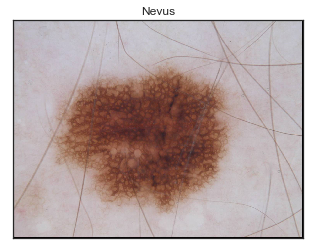

In [5]:
img = mpimg.imread('dataskin/Train/nevus/ISIC_0000019.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Nevus')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Vascular lesion**
<br>Cutaneous vascular lesions are the most common pediatric birthmarks. Flat vascular malformations tend to persist, but raised vascular lesions, known as hemangiomas, generally involute.
Vascular birthmarks are commonly encountered in children and are classified as either hemangiomas or vascular malformations. 
<br>Hemangiomas are benign neoplastic proliferations of vascular endothelial cells characterized by spontaneous involution. In contrast, vascular malformations are not neoplasms but permanent morphogenic abnormalities of capillaries, veins, arteries or lymphatic vessels. <br>Flat lesions (vascular malformations) tend to persist, while raised lesions (hemangiomas) tend to regress.

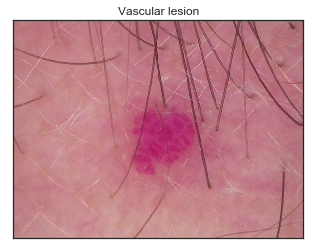

In [6]:
img = mpimg.imread('dataskin/Train/vascular lesion/ISIC_0024475.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Vascular lesion')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

### Malignant Classes:
**Actinic keratosis**
<br>An actinic keratosis is a rough, scaly patch on the skin that develops from years of sun exposure. It's often found on the face, lips, ears, forearms, scalp, neck or back of the hands.
<br>Actinic keratoses (AKs) are pre-malignant since they may progress to squamous cell carcinoma. They are a common skin condition and develop in sun-exposed skin of individuals with cumulative sun exposure.
<br>Also known as a solar keratosis, an actinic keratosis grows slowly and usually first appears in people over 40.
<br>Left untreated, the risk of actinic keratosis turning into a type of skin cancer called squamous cell carcinoma is about 5% to 10%. 

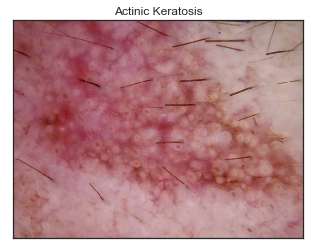

In [7]:
img = mpimg.imread('dataskin/Train/actinic keratosis/ISIC_0025780.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Actinic Keratosis')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Basal cell carcinoma**
<br>Basal cell carcinoma is a type of skin cancer. Basal cell carcinoma begins in the basal cells — a type of cell within the skin that produces new skin cells as old ones die off.

Basal cell carcinoma often appears as a slightly transparent bump on the skin, though it can take other forms. Basal cell carcinoma occurs most often on areas of the skin that are exposed to the sun, such as your head and neck.

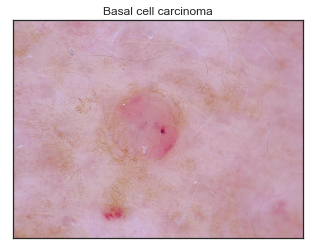

In [8]:
img = mpimg.imread('dataskin/Train/basal cell carcinoma/ISIC_0024572.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Basal cell carcinoma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Melanoma**
<br>Melanoma, the most serious type of skin cancer, develops in the cells (melanocytes) that produce melanin — the pigment that gives your skin its color. Melanoma can also form in your eyes and, rarely, inside your body, such as in your nose or throat.

The exact cause of all melanomas isn't clear, but exposure to ultraviolet (UV) radiation from sunlight or tanning lamps and beds increases your risk of developing melanoma.
<br>The risk of melanoma seems to be increasing in people under 40, especially women. Knowing the warning signs of skin cancer can help ensure that cancerous changes are detected and treated before the cancer has spread. Melanoma can be treated successfully if it is detected early.

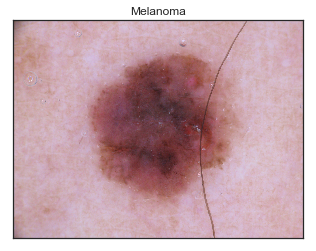

In [9]:
img = mpimg.imread('dataskin/Train/melanoma/ISIC_0000139.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Melanoma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Squamous cell carcinoma**
<br>Squamous cell carcinoma of the skin is a common form of skin cancer that develops in the squamous cells that make up the middle and outer layers of the skin.

Squamous cell carcinoma of the skin is usually not life-threatening, though it can be aggressive. Untreated, squamous cell carcinoma of the skin can grow large or spread to other parts of your body, causing serious complications.

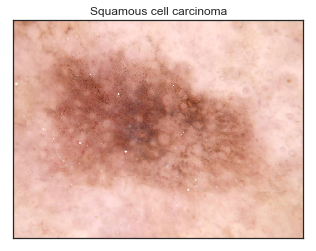

In [10]:
img = mpimg.imread('dataskin/Train/squamous cell carcinoma/ISIC_0024843.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Squamous cell carcinoma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

All these informations are taken from the [Mayo Clinic Website](https://www.mayoclinic.org/.) the [National Canter of Biotechonology Website](https://www.ncbi.nlm.nih.gov/) and the [American Family Physician Website](https://www.aafp.org/).

### Data Preparation:

How does Python read images?

The images are expressed as matrices, in which the size is the same as the picture size.
If the images are black and white the matrix is only one, while is the image is in colors, the matrices are 3, overlapped, one for color Red, one for Green and one for Blue.
The numbers in each of the three matrices corresponds with the pixel intensity values in each of the three colors. The pixel intensity values are in the scale [0,255]

In [11]:
train_images_fs[0]

array([[[143., 114., 106.],
        [144., 117., 108.],
        [146., 124., 113.],
        ...,
        [126., 108.,  94.],
        [122., 104.,  92.],
        [116.,  98.,  88.]],

       [[145., 118., 109.],
        [144., 120., 110.],
        [148., 128., 117.],
        ...,
        [127., 110.,  94.],
        [124., 106.,  92.],
        [117.,  99.,  87.]],

       [[145., 123., 112.],
        [150., 130., 119.],
        [151., 133., 121.],
        ...,
        [132., 113.,  96.],
        [124., 105.,  91.],
        [123., 104.,  90.]],

       ...,

       [[143., 113.,  87.],
        [151., 123.,  99.],
        [155., 129., 106.],
        ...,
        [136., 121., 102.],
        [132., 115.,  99.],
        [131., 112.,  98.]],

       [[141., 113.,  89.],
        [148., 122.,  99.],
        [153., 128., 106.],
        ...,
        [134., 119., 100.],
        [127., 110.,  94.],
        [124., 105.,  91.]],

       [[142., 114.,  90.],
        [145., 119.,  96.],
        [147., 1

Previewing one of the images from the train:

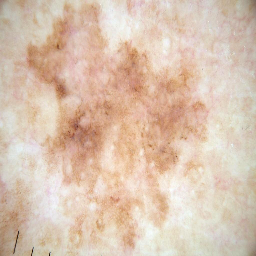

In [12]:
# Preview an image
array_to_img(train_images_fs[0])

Previewing one of the images form the test:

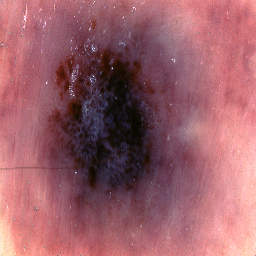

In [13]:
# Preview an image
array_to_img(test_images_fs[0])

Let us look at the shape of our data.
<br>First the labels:

In [14]:
train_labels.shape

(2239, 9)

In [15]:
test_labels.shape

(118, 9)

This makes sense since we have 2239 images for the train and 118 for the test, and they are divided in 9 classes.
<br>Now the images:

In [16]:
test_images_fs.shape

(118, 256, 256, 3)

In [17]:
train_images_fs.shape

(2239, 256, 256, 3)

Same number for the images of train and test, 256x256 is the size of the images, and the 3 is because it's 3 matrices, one for each color pixels RGB.
<br>Let us generate a dataframe to do some more EDA.

In [18]:
dataframe_train=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

Previewing the different classes and their labels:

In [19]:
dataframe_train

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2236,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Next we are going to sum the instances for each class to get a sense of how many images we have per class:

In [20]:
sums=dataframe_train.sum(axis=0)
sums=pd.DataFrame(sums)
sums.rename(columns={0: "Counts"}, inplace=True)
sums

,Counts
actinic_keratosis,114.0
basal_cell_carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented_benign_keratosis,462.0
seborrheic_keratosis,77.0
squamous_cell_carcinoma,181.0
vascular_lesion,139.0


It seems that benign keratosis, melanoma and basal cell carcinoma are the most represented classes.
<br>Class imbalance might be something to worry about, but that would be a concern mostly when we switch to a binary classification problem, with "benign" and "cancerous" classes.
<br>Converting the sum column into percentages.

In [21]:
sums['%'] = (((sums['Counts']*100)/2239).round(2))
sums

,Counts,%
actinic_keratosis,114.0,5.090000
basal_cell_carcinoma,376.0,16.790001
dermatofibroma,95.0,4.240000
melanoma,438.0,19.559999
nevus,357.0,15.940000
pigmented_benign_keratosis,462.0,20.629999
seborrheic_keratosis,77.0,3.440000
squamous_cell_carcinoma,181.0,8.080000
vascular_lesion,139.0,6.210000


Let us sum together the instances of classes that are benign and cancerous:

In [22]:
total_benign=np.sum([sums['%']['dermatofibroma'], sums['%']['pigmented_benign_keratosis'], 
                    sums['%']['nevus'], sums['%']['seborrheic_keratosis'], 
                    sums['%']['vascular_lesion']])
total_benign

50.459995

In [23]:
total_cancerous=np.sum([sums['%']['melanoma'], sums['%']['actinic_keratosis'], 
                    sums['%']['basal_cell_carcinoma'], sums['%']['squamous_cell_carcinoma']])
total_cancerous

49.520004

Plotting those distributions:

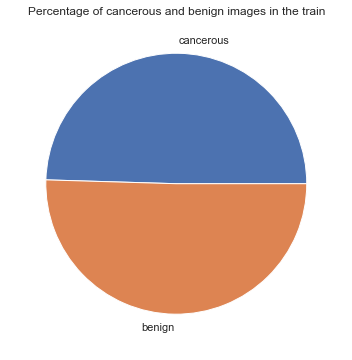

In [24]:
totals_train=pd.Series([total_cancerous, total_benign])
totals_train.to_frame()
plt.figure(figsize=(6,6))
plt.title('Percentage of cancerous and benign images in the train')
plt.pie(totals_train,labels=['cancerous', 'benign']);

We can see that in terms of benign and cancerous, the classes are well balanced on the train set.

Showing in a histogram the distribution of the different images in the train set

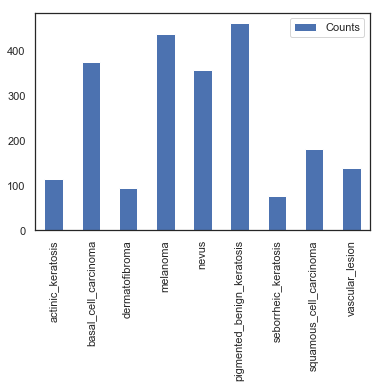

In [25]:
sums['Counts'].plot(kind='bar', legend=True);

Repeating the same for the test set:

In [26]:
dataframe_test=pd.DataFrame(test_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])
sums_test=dataframe_test.sum(axis=0)
sums_test=pd.DataFrame(sums_test)
sums_test.rename(columns={0: "Counts"}, inplace=True)

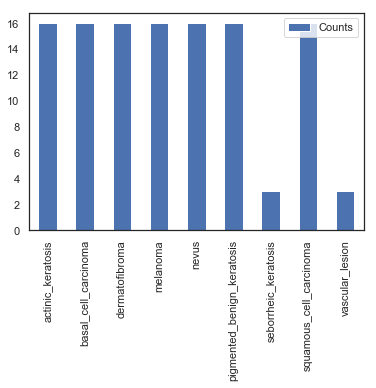

In [27]:
sums_test['Counts'].plot(kind='bar', legend=True);

It seems like in the test the classes are more equally represented, except for seborrheic keratosis and vascular lesion.
<br>Calculating once again the percentages:

In [28]:
sums_test['%'] = ((sums_test['Counts'] / 118*100).round(2))
sums_test

,Counts,%
actinic_keratosis,16.0,13.56
basal_cell_carcinoma,16.0,13.56
dermatofibroma,16.0,13.56
melanoma,16.0,13.56
nevus,16.0,13.56
pigmented_benign_keratosis,16.0,13.56
seborrheic_keratosis,3.0,2.54
squamous_cell_carcinoma,16.0,13.56
vascular_lesion,3.0,2.54


Summing up values for benign and malignant:

In [29]:
total_benign=np.sum([sums_test['%']['dermatofibroma'], 
                     sums_test['%']['pigmented_benign_keratosis'], 
                    sums_test['%']['nevus'], sums_test['%']['seborrheic_keratosis'], 
                    sums_test['%']['vascular_lesion']])
total_benign

45.760002

In [30]:
total_cancerous=np.sum([sums_test['%']['melanoma'], 
                        sums_test['%']['actinic_keratosis'], 
                    sums_test['%']['basal_cell_carcinoma'], 
                        sums_test['%']['squamous_cell_carcinoma']])
total_cancerous

54.24

Plotting again the distribution:

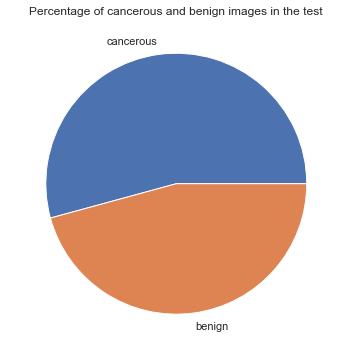

In [31]:
totals_test=pd.Series([total_cancerous, total_benign])
totals_test.to_frame()
plt.figure(figsize=(6,6))
plt.title('Percentage of cancerous and benign images in the test')
plt.pie(totals_test,labels=['cancerous', 'benign']);

For the test set, the percentage of malignant is 54% and benign is 46%.
Still a good balance between the two classes.
<br>In terms of the division between 9 classes, it could be a problem because the distribution between the classes is different, this might be what could bring a problem to the model that hasn't learnt how to identify specific classes, that are less present in the train and much more the test. Namely seborrheic keartosis and dermatofibroma.
<br>This could be a possible cause of lower performance.

#### Importing images

We are going to re-import our images with a lower resolution, since we want the models to be faster especially since we want to try a lot of them.
<br>Starting with a very small sixe, 8x8 for our naive model. We will increase it as we proceed to improve the models.

In [32]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(8, 8), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=2239)

# Create the datasets
train_img8, train_lab = next(train_gen)
test_img8, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


Exploring the shape of images and labels in our dataset:

In [33]:
# Explore your dataset
m_train = train_img8.shape[0]
num_px = train_img8.shape[1]
m_test = test_img8.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_img8.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img8.shape))
print ("test_labels shape: " + str(test_lab.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 8, 8, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 8, 8, 3)
test_labels shape: (118, 9)


In [34]:
train_lab

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
test_lab

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

We can see here that we have need to do some data manipulation.
<br>Each class here is marked as '1' but we actually want each class to be marked with its corresponding class index.
<br>We will preview the class index below and then do some data manipulation on the DataFrame, to make it more visibly clear, to prepare our labels properly to be fed into the model.

In [36]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

While in our dataframe (and the train_label array that we got the dataframe from) they are:

In [37]:
dataframe_train

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2236,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We will go ahead and substitute the '1' index in the columns with their correct class index.

In [38]:
dataframe_train.replace({'actinic_keratosis': 1.0}, 0, inplace=True)
dataframe_train.replace({'basal_cell_carcinoma': 1.0}, 1, inplace=True)
dataframe_train.replace({'dermatofibroma': 1.0}, 2, inplace=True)
dataframe_train.replace({'melanoma': 1.0}, 3, inplace=True)
dataframe_train.replace({'nevus': 1.0}, 4, inplace=True)
dataframe_train.replace({'pigmented_benign_keratosis': 1.0}, 5, inplace=True)
dataframe_train.replace({'seborrheic_keratosis': 1.0}, 6, inplace=True)
dataframe_train.replace({'squamous_cell_carcinoma': 1.0}, 7, inplace=True)
dataframe_train.replace({'vascular_lesion': 1.0}, 8, inplace=True)

Now we can see the different labels in each column:

In [39]:
dataframe_train

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2236,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0


Creating a new column '1D' that will be our 1 dimensional array of labels.

In [40]:
dataframe_train['1D']=dataframe_train['actinic_keratosis']+dataframe_train['basal_cell_carcinoma']+dataframe_train['dermatofibroma']+dataframe_train['melanoma']+dataframe_train['nevus']+dataframe_train['pigmented_benign_keratosis']+ dataframe_train['seborrheic_keratosis']+dataframe_train['squamous_cell_carcinoma']+dataframe_train['vascular_lesion']
dataframe_train

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion,1D
0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,7.0
3,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0
2236,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,7.0


In [41]:
train_array=dataframe_train['1D'].to_numpy()
train_array

array([3., 5., 7., ..., 1., 7., 5.], dtype=float32)

We can see how now the labels are condensed into one array. We are going to define this as our train_y.

In [42]:
train_y=train_array

In [43]:
train_y.shape

(2239,)

Repeating the same for the test labels:

In [44]:
dataframe_test.replace({'actinic_keratosis': 1.0}, 0, inplace=True)
dataframe_test.replace({'basal_cell_carcinoma': 1.0}, 1, inplace=True)
dataframe_test.replace({'dermatofibroma': 1.0}, 2, inplace=True)
dataframe_test.replace({'melanoma': 1.0}, 3, inplace=True)
dataframe_test.replace({'nevus': 1.0}, 4, inplace=True)
dataframe_test.replace({'pigmented_benign_keratosis': 1.0}, 5, inplace=True)
dataframe_test.replace({'seborrheic_keratosis': 1.0}, 6, inplace=True)
dataframe_test.replace({'squamous_cell_carcinoma': 1.0}, 7, inplace=True)
dataframe_test.replace({'vascular_lesion': 1.0}, 8, inplace=True)

In [45]:
dataframe_test

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
1,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
3,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
113,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
dataframe_test['1D']=dataframe_test['actinic_keratosis']+dataframe_test['basal_cell_carcinoma']+dataframe_test['dermatofibroma']+dataframe_test['melanoma']+dataframe_test['nevus']+dataframe_test['pigmented_benign_keratosis']+ dataframe_test['seborrheic_keratosis']+dataframe_test['squamous_cell_carcinoma']+dataframe_test['vascular_lesion']

In [47]:
test_array=dataframe_test['1D'].to_numpy()

In [48]:
test_y=test_array

#### Building functions:

Building some functions that will help us visualize and compare the different models.
<br>The first function we are defining is to visualize the curve of accuracy and loss, as they develop along the epochs, both for the train and validation set. <br>We are extracting these values from the history that the model produces once it is fit.

In [49]:
def visualize_training_results(results):
#Extracting the history from the results of the model
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#Plotting Train and Validation Accuracy
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
#Setting legend, title and labels
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
#Plotting Train and Validation Loss    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
#Setting legend, title and labels
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Creating the empty DataFrame where we will store the results:

In [50]:
# create an Empty DataFrame object
df9 = pd.DataFrame()

Defining a function to fit the model and get the results. Also here we can set number of epochs, batch size and validation split, but there are default parameters too.
In particular we set verbose to zero because we don't want to print out the fitting of all the models.
We also set a default validation split of 20%, which is a standard amount, to have a part of the data that the model can do validation on.

In [51]:
#Defining function with some sest parameters
def fit_model(model, X, y, epo=15, batch=30, val_split=0.2, verbose=0):
    #Fitting the model and storing the results in the variable 'results'
    results = model.fit(X, y, epochs=epo, batch_size=batch, 
                        validation_split=val_split, verbose=verbose)
    return results

Because of the stochastic nature of Neural Networks, it is going to be hard to get consistent results.
<br>What we can do to avoid this problem is to fit the model several times, and keep as a result the mean of the result.
<br>Let us create a function to do that.

In [52]:
#Defining the function
def statistic_results(model, trainX, trainy, epochs=20, batch=50):
#Creating the empty lists that will contain the results
    accu_train=[]
    accu_val=[]
    loss_train=[]
    loss_val=[]
#Creating a for cycle that will repeat the fitting process of the model 10 times
    for i in range(10):
        resu=fit_model(model, trainX,
                    trainy, epo=epochs, batch=batch)
        #Appending accuracy and loss of both validation and train
        accu_train.append(round(resu.history['acc'][-1],5))
        accu_val.append(round(resu.history['val_acc'][-1],5))
        loss_train.append(round(resu.history['loss'][-1],5))
        loss_val.append(round(resu.history['val_loss'][-1],5))
        i+=1
    #Calculating the mean accuracy and loss, of both validation and train
    mean_acc_train=np.mean(accu_train)
    mean_acc_val=np.mean(accu_val)
    mean_loss_train=np.mean(loss_train)
    mean_loss_val=np.mean(loss_val)
    #Calculating the standard deviation of accuracy and loss
    std_at=np.std(accu_train)
    std_av=np.std(accu_val)
    std_lt=np.std(loss_train)
    std_lv=np.std(loss_val)
    #Creating a dictionary that contains all the calculated values that the function will return
    return ({'Mean_accuracy_train': mean_acc_train, 
             'Mean_accuracy_validation': mean_acc_val, 
             'Mean_loss_train': mean_loss_train, 
             'Mean_loss_validation': mean_loss_val,
             'Std_acc_train': std_at,
             'Std_acc_val': std_av,
             'Std_loss_train': std_lt,
             'Std_loss_val': std_lv})    
                        

At last we are going to be creating a function to preview and store the results of our models.
<rb>With this function we will display the evolution of accuracy and loss in our model, during the different epochs.
<br>Below that we will see also the values of accuracy and loss and over time we will build a learning curve, adding the result of each previous model and the current one, to see if our model is improving.
<br>We are also saving the results into a DataFrame that we will keep updating with the new results, to have them also in a convenient tabular format.

In [53]:
#Defining the function
def model_results(model, results, model_name, df, trainX, trainy ):
    #First we want the function to display the history of accuracy and loss, with the function previously defined
    visualize_training_results(results)
    #Producing the stats
    stats=statistic_results(model, trainX, trainy)
    #Creating a temporary DataFrame to store the results obtained
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': stats['Mean_accuracy_train'] ,
        'accuracy validation': stats['Mean_accuracy_validation'],
        'loss train': stats['Mean_loss_train'],
        'loss validation': stats['Mean_loss_validation']})
    #Appending the results of the current model to the general DataFrame 'df' with results of all models
    df=df.append(df1)
    #Plotting learning curves of Accuracy and Loss
    fig = plt.subplots(figsize=(12,6))
    #First Subplot, accuracy of train and validation
    #This takes resulta from df, plotting the results from current and previous models
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
    #Second Subplot, loss of train and validation
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

## 9 Classes Models <a id='9clas'></a>
The models are all going to be convolutional neural networks.
<br>They consist of convolutional layers and pooling layers. 
<br>The first convolutional layers are trying to learn local patterns, and the deeper convolutional layers can learn spatial hierarchies.
<br>An example to clarify is the first layers of the model starting by identifying a leaf, and the deeper layers learning to identify a branch and then a tree.
<br>How convolutional layers are learnign this is by sliding a filter (of weights) over the image matrix to produce a new matrix of values. This is done so that the model can be able to capture edges that delimit one structure or pattern from another one, that is either the background or a different object. (like distinguishing the leaf from the background, or the branch or trunk of the tree).

The next layer we have is a pooling layer. Pooling is to reduce dimensionality. <br>Max pooling breaks down the matrix into sections. I am trying to pull out the main features and forget about the granular details. <br>It essentially takes a summary of a feature that was detected and discards the rest. Parameters are f, filter size, and s stride.
<br>Stride is the pace at which I slide the filter over. A bigger stride results in a smaller image output.
<br>After the Convolutional base, we then add a dense layer on top, but first we have to flatten it using a `Flatten()` layer.

We chose Accuracy and Loss as metrics to evaluate our models.
<br>The accuracy represents the number of true positive plus the number of true negatives, divided by the total of observations. It allows us to measure the total number of predictions that our model got right, it is the most common metric for classification because it gives a solid and comprehensive view of the overall performance of the model.
<br>The loss indicates the inconsistency between the predicted value and the actual real label of the image.
<br>We want this value to decrease over time, as the model is learning and adjusting the weights to reduce its error.
<br>It gives us an overall sense of the error of our model.

### Naive model

Creating a first basic model.
<br>This model will have images of size 8x8 as input, and only one convolutional layer with 3 neurons, and one pooling layer.
<br>The final Dense layer has to have 9 neurons because that corresponds with the number of classes that we are trying to identify for our images.

In [54]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(8,8,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(9, activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Fitting the model and getting results.

In [55]:
history = fit_model(model, train_img8, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
180/180 [==============================] - 2s 7ms/step - loss: 33.6240 - acc: 0.1544 - val_loss: 2.2112 - val_acc: 0.1540
Epoch 2/10
180/180 [==============================] - 0s 2ms/step - loss: 2.2393 - acc: 0.1668 - val_loss: 2.1268 - val_acc: 0.2098
Epoch 3/10
180/180 [==============================] - 0s 2ms/step - loss: 2.1326 - acc: 0.1849 - val_loss: 2.0933 - val_acc: 0.2076
Epoch 4/10
180/180 [==============================] - 0s 2ms/step - loss: 2.0918 - acc: 0.2330 - val_loss: 2.0743 - val_acc: 0.2098
Epoch 5/10
180/180 [==============================] - 0s 2ms/step - loss: 2.0747 - acc: 0.2089 - val_loss: 2.0561 - val_acc: 0.2076
Epoch 6/10
180/180 [==============================] - 0s 2ms/step - loss: 2.0447 - acc: 0.2204 - val_loss: 2.0486 - val_acc: 0.2076
Epoch 7/10
180/180 [==============================] - 0s 2ms/step - loss: 2.0411 - acc: 0.2177 - val_loss: 2.0383 - val_acc: 0.2076
Epoch 8/10
180/180 [==============================] - 1s 3ms/step - loss: 2

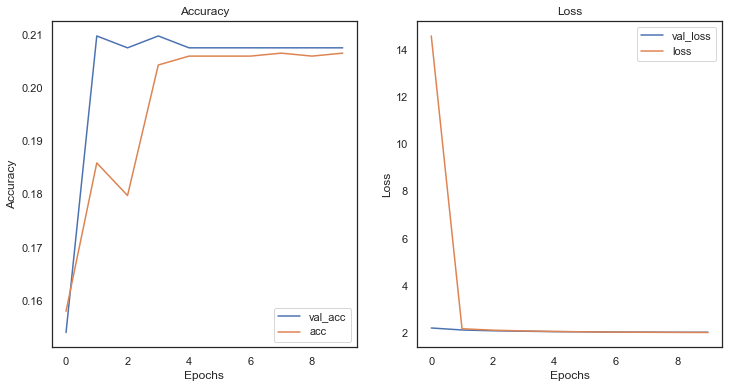

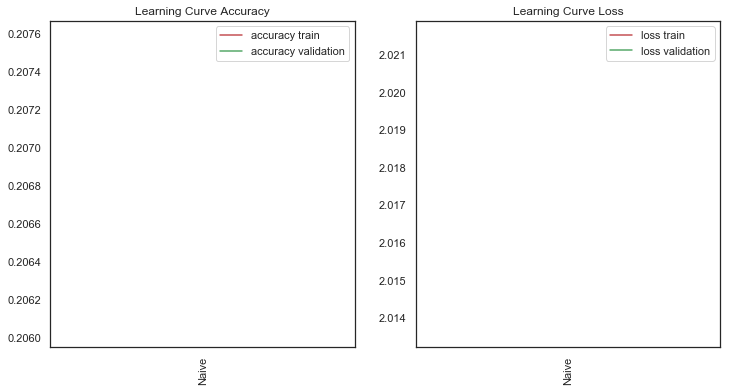

In [56]:
df9=model_results(model, history, 'Naive', df9, train_img8, train_y)

For now the bottom two graphs are empty because we have only 1 point in our learning curve for both loss and accuracy, but as we keep building models those visuals will be very helpful to see in which direction we are moving.
<br>Calculating some statistics on our result with our designated function:

In [57]:
stats=statistic_results(model, train_img8,train_y)

In [58]:
stats

{'Mean_accuracy_train': 0.20603,
 'Mean_accuracy_validation': 0.20759,
 'Mean_loss_train': 2.0135700000000005,
 'Mean_loss_validation': 2.02147,
 'Std_acc_train': 0.0,
 'Std_acc_val': 0.0,
 'Std_loss_train': 4.440892098500626e-16,
 'Std_loss_val': 0.0}

In [59]:
stats['Mean_accuracy_train']

0.20603

We can see that even our beginning naive model has a pretty low accuracy, around 20%.
<br>But we will take all the necessary steps to tune it and improve it.
<br>We want to note that around 20% makes sense as accuracy for a naive model because of the distribution of the 9 classes, or actually even slightly higher than a default baseline. <br>If we had only 2 classes we would expect the accuracy for a baseline model to be around 50%, because just by random guess we would get 50% accuracy.<br>With 9 classes the default accuracy by random choice would be about 11%.

## Starting to improve our model:

### To improve our model we will take several steps:
   - normalize the data 
   - increase image resolution
   - add more epochs
   - add more layers
   - increase the batch size
   - select the best optimization algorithm
   - tune the optimization algorithm learning rate
   - select best activation function
   - tune number of neurons in the layers
   
<br>After this, we will do another round of tuning for the model, this time using:
 - regularization
 - drop out layers

## Improving the model with 9 classes:

The first step to improve our model is to normalize the data.

### Normalize the data:
As we have seen before the images are in the format of matrices that express the intensity of the color Red Green or Blue for each pixel.
The pixel values are expressed on a scale from 0 to 255, as we can see below:

In [60]:
train_img8[0][1]

array([[233., 201., 238.],
       [227., 159., 200.],
       [238., 186., 232.],
       [235., 176., 220.],
       [247., 206., 246.],
       [248., 216., 255.],
       [243., 211., 250.],
       [243., 212., 253.]], dtype=float32)

As we can see the RGB values of each pixel are not scaled, we are going to scale their value between 0 and 1 by dividing each pixel value by 225, which has proven usually helpful in increasing model performance.
To standardize the pixel values:

In [61]:
train_img8 /= 255.

In [62]:
train_img8[0][1]

array([[0.9137255 , 0.7882353 , 0.93333334],
       [0.8901961 , 0.62352943, 0.78431374],
       [0.93333334, 0.7294118 , 0.9098039 ],
       [0.92156863, 0.6901961 , 0.8627451 ],
       [0.96862745, 0.80784315, 0.9647059 ],
       [0.972549  , 0.84705883, 1.        ],
       [0.9529412 , 0.827451  , 0.98039216],
       [0.9529412 , 0.83137256, 0.99215686]], dtype=float32)

Now the pixels are expressed in values between 0 and 1.
<br>We move on to fit our model and preview the results.

In [63]:
history1 = fit_model(model, train_img8, train_y)

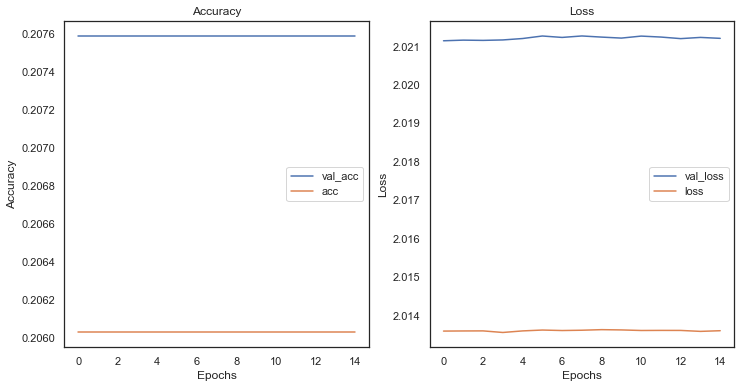

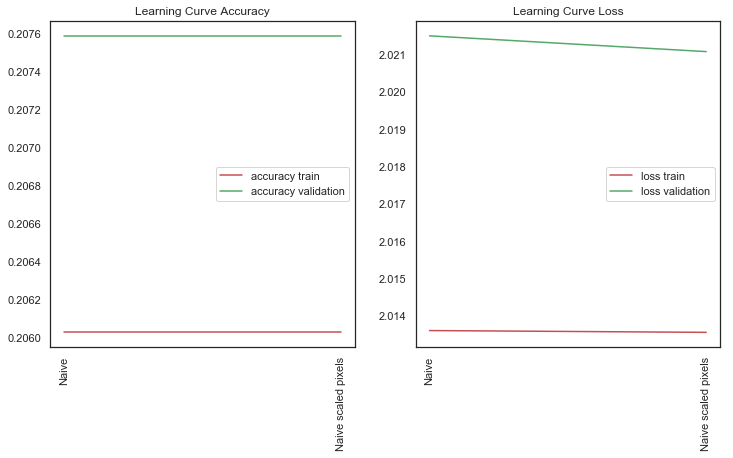

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.20603,0.20759,2.013618,2.021507
0,Naive scaled pixels,0.20603,0.20759,2.013570,2.021085


In [64]:
df9=model_results(model, history1, 'Naive scaled pixels', df9, train_img8, train_y)
df9

On average - at this point we saw the accuracy of the train went up, but the accuracy of the validation set decreased.
<br>The loss of the train decreased but the one of the validation increased.
<br>Netx - to make the model more advanced we are going to add more layers and increase the images resolution.

### Adding more layers and using higher resolution images:

Let us move on from the basic naive model to a more structured one with more layers.
<br>Hidden layers of the network are like the latent features (hidden criteria) which are linear combinations of the input features.

As we mentioned convolutional layers learn local patterns. Deeper convolutional layers and networks can learn spatial hierarchies.
<br>The loss function is used to measure the inconsistency between the predicted value y hat and the actual label y.
<br>The loss function is defined over one particular training sample while the cost function take the average loss over all the samples.
<br>What we try to do adjusting the weights is to minimize the cost function.
<br>In particular with CNN: we are choosing as a loss function sparse categorical crossentropy because images are sparse matrices.

We will define a function that will allow us to also tweak other parameters, which is what we will do to keep tuning our model.
<br>With this function we can set all the parameters that we want, input_shape, activation function, loss, optimizer algorithm, metrics etc.
<br>We will also set most of these parameters as default, to make the execution of the function not too heavy.

In [65]:
def create_model(input_shape=(64, 64, 3), activation='relu', 
                 loss='sparse_categorical_crossentropy', 
                optimizer='rmsprop',metrics=['acc'] , 
                 neur1=10, neur2=20, pool=(2,2)):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    return model

Let us import images with resolution 32x32, and create a model with more layers.

In [66]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=2239)

# Create the datasets
train_img32, train_lab = next(train_gen)
test_img32, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


Creating, fitting and extracting results for the model:

In [67]:
model_a=create_model(input_shape=(32,32,3))

In [68]:
history2 = fit_model(model_a, train_img32, train_y)

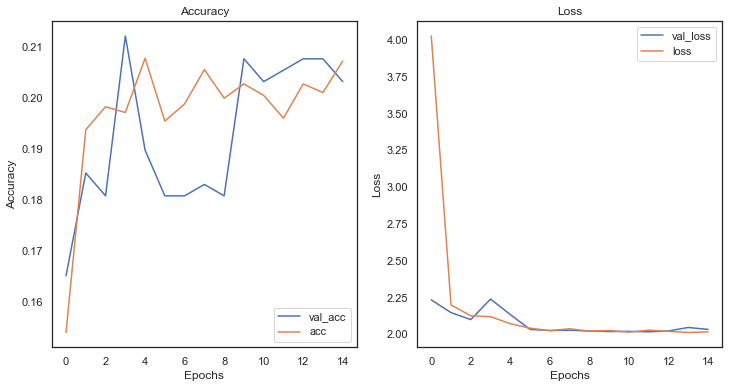

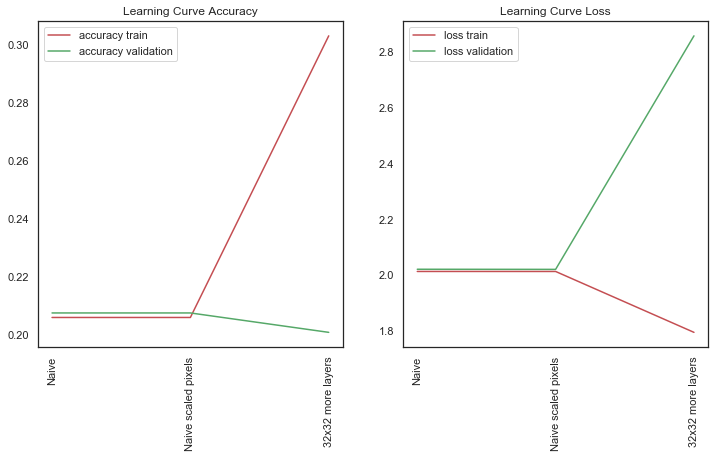

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512


In [69]:
df9=model_results(model_a, history2, '32x32 more layers', df9, train_img32, train_y)
df9

What we saw on average at this point is that the accuracy of train went up but the accuracy of the validation set went down or stayed the same. We start to see overfitting.
<br>This is confirmed by the fact that loss of train went down, but loss of accuracy went way up.
<br>Next we are going to increase the image resolution even further, hoping that the model can learn better how to generalize with images also from the validation set, and unknown data.

### Further increasing image resolution:
Next to improve our model we will use images with a higher resolution to improve the performance.
Importing images with 64x64 image resolution:

In [70]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Create the datasets
train_img64, train_lab = next(train_gen)
test_img64, test_lab = next(test_gen)

#normalizing again
train_img64 /= 255.
test_img64 /= 255.

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


We need to create another model, since the input shape changed:

In [71]:
# No need to specify input shape, since the default is 64x64
model_b=create_model()

Fitting the model

In [72]:
history3 = fit_model(model_b, train_img64, train_y)

Let us visualize the results:

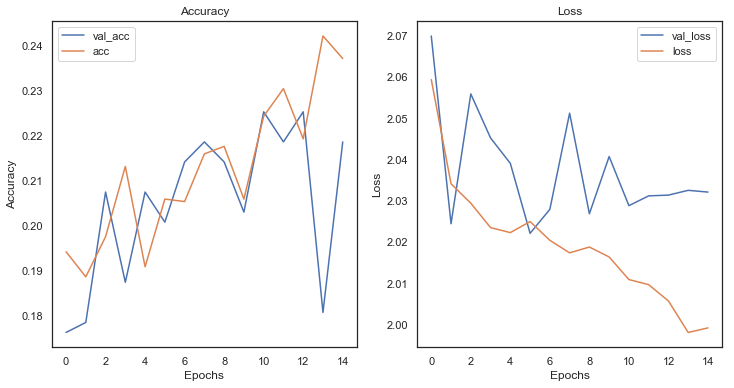

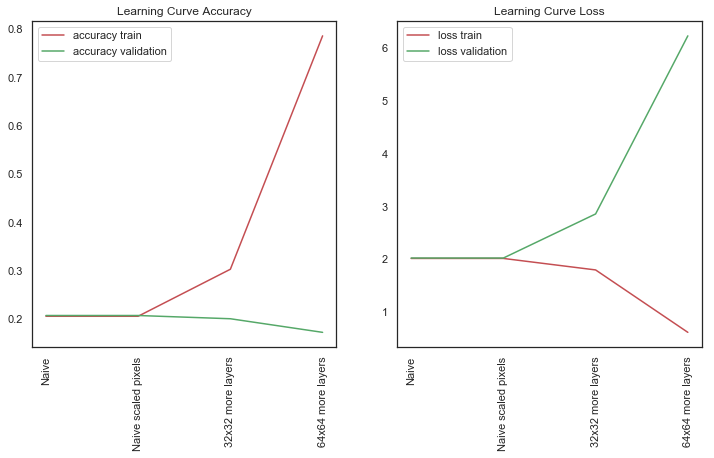

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788


In [73]:
df9=model_results(model_b, history3, '64x64 more layers', df9,train_img64, train_y )
df9

On average here we see again overfitting, with the accuracy of the train going up and the validation accuracy going down or staying the same.
<br>Loss of the train decreased, but loss of the validation kept rising.
<br>We will deal with overfitting at the end, using some tuning with L2 regularization and Dropout regularization.
<br>In the meanwhile we will continue to try improving our model, tuning all the parameters we can to try to make our model as precise as possible, on both the train and validation set.

In the next code block we are adding these 64x64 images as the default in our `model_results` function since they'll be the ones we'll be using the most.

In [74]:
#Only changing the default trainX and trainy, everything else staying the same as above.
def model_results(model, results, model_name, df9, trainX=train_img64, trainy=train_y ):
    visualize_training_results(results)
    stats=statistic_results(model, trainX, trainy)
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': stats['Mean_accuracy_train'] ,
        'accuracy validation': stats['Mean_accuracy_validation'],
        'loss train': stats['Mean_loss_train'],
        'loss validation': stats['Mean_loss_validation']})
    df9=df9.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df9['Name']
    y=df9['accuracy train']
    plt.plot(x, y, color='r')
    x1=df9['Name']
    y1=df9['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df9['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df9['Name']
    y=df9['loss train']
    plt.plot(x, y, color='r')
    x1=df9['Name']
    y1=df9['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df9['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df9

### Increasing number of epochs:
Keeping the same model, but we run the model longer, for 30 epochs.
<br>Every epoch is the time to do forward and backward propagation.
<br>The more epochs the more times the model goes back and forth between assigning weights, calculating the results, comparing with the labels and doing backpropagation, correcting the weights in the direction that helps us to minimize the cost function.
<br>We hope this will help the model learn better the patterns of the images and converge to lower values of loss.

In [75]:
history4 = fit_model(model_b, train_img64, train_y, epo=30)

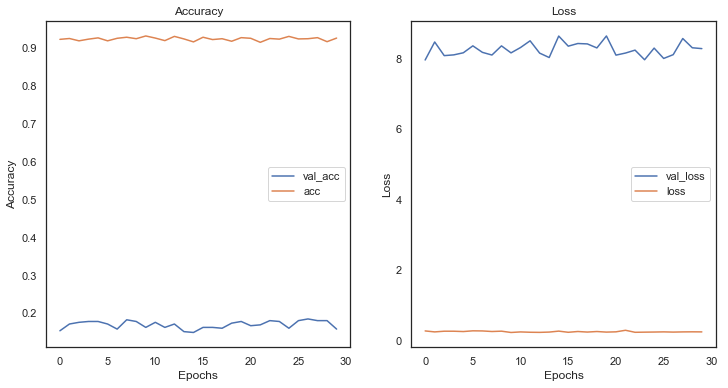

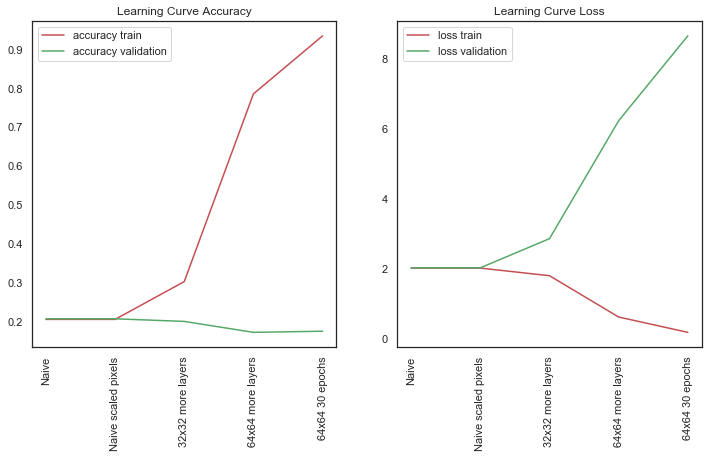

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788
0,64x64 30 epochs,0.934897,0.175671,0.172830,8.667449


In [76]:
df9=model_results(model_b, history4, '64x64 30 epochs', df9)
df9

We keep seeing on average an increase of the model accuracy on the train, which means the model overall is learning more, reaching an accuracy of about 90%, but we also continue seeing overfitting on the validation set, where the accuracy is staying around the 15-20% value.
<br>Let us note that 15-20% is roughly the accuracy obtained by the naive model.
<br>Overfitting is confirmed by decrease of loss in train set, and increase of loss in the validation set.

### Increase the batch size: 50

This time we will increase the batch size, which is the group of pictures taken at a time by the model to work on.
<br>Having a bigger batch should help the model learn more about unseen data.

Fitting the model and calculating results:

In [77]:
history5 = fit_model(model_b, train_img64, train_y, epo=30, batch=50)

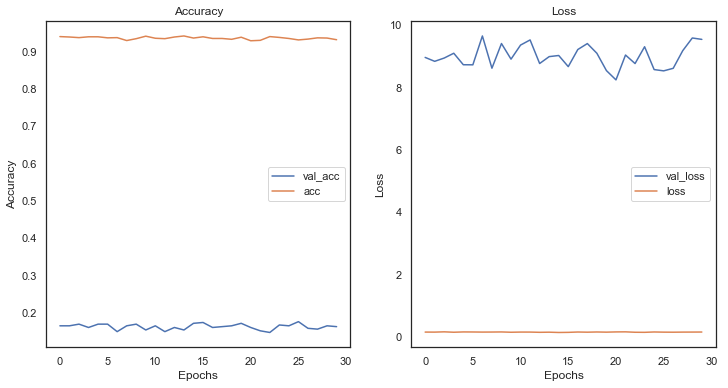

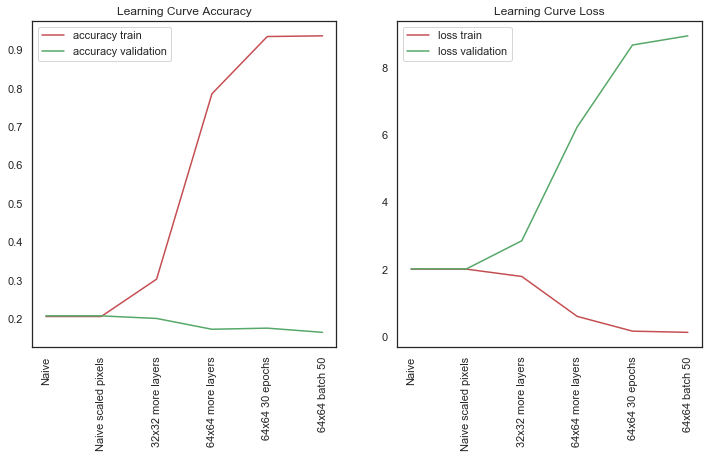

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788
0,64x64 30 epochs,0.934897,0.175671,0.172830,8.667449
0,64x64 batch 50,0.936685,0.164731,0.137188,8.939835


In [78]:
df9=model_results(model_b, history5, '64x64 batch 50', df9)
df9

After the change in batch size the results on average stayed around the same value, both for accuracy and loss.
<br>We might need to increase the size of the batch even more to see relevant results.
<br>But the truth is that just getting one result for each of these attempts doesn't really tell us too much about the improvement or not of our model, because of the randomness of the results.
<br>What would be more appropriate is for each change we do in our tuning process, to try a few different values to be able to really get a sense of in which direction our model is moving with that change.
<br>This would be very time consuming to do by hand, so the next step we are going to take is building a grid search for these parameters to get a better answer in terms of which ones are the optimal characteristic of our model, which gives us the best accuracy in determining the classification of the skin anomaly.

### Grid Search batch size and epochs:

Grid search is a model hyperparameter optimization technique.
In scikit learn this is a class, and when running a search with this class, we must input a dictionary of hyperparameters to evaluate in the param_grid argument. 
<br>This dictionary contains the model parameter name and an array of values to try.

The GridSearchCV essentially builds and then evaluates one model for each combination of parameters. 
<br>To evaluate each individual model, a 3-fold cross validation is used.

Once we  find out from the GridSearch what are the best parameters we can use those (running just one single model) with higher resolution images.

Since GridSearch takes a long time to run, for this one and also the following ones we included the code but commented it out, so that it can be used again to run more grid searches also with different dataset.
<br>We are saving the parameters that were identified by the search as the best ones (see below) so that the search doesn't need to be re run every time.

In [79]:
"""
# Use scikit-learn to grid search the batch size and epochs
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model())
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

'\n# Use scikit-learn to grid search the batch size and epochs\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n\n#set X and Y\nX=train_img64\nY=train_y\n# create model\nmodel = KerasClassifier(model=create_model())\n# define the grid search parameters\nbatch_size = [10, 20, 40, 60, 80, 100]\nepochs = [10, 50, 100]\nparam_grid = dict(batch_size=batch_size, epochs=epochs)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n#'

In [80]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n#    '

In [81]:
#best_params=grid_result.best_params_
#best_params

Defining as `best_batch` the result from the grid search: 100.

In [82]:
#best_batch=best_params['batch_size']

In [83]:
best_batch=100

Defining as `best_epochs` the result form the grid search: 10.

In [84]:
#best_epochs=best_params['epochs']

In [85]:
best_epochs=10

Now we can run again a model with the higher resolution images, using the best parameters we obtained from the grid search.

In [86]:
history6 = fit_model(model_b, train_img64, train_y, epo=best_epochs,
                    batch=best_batch)

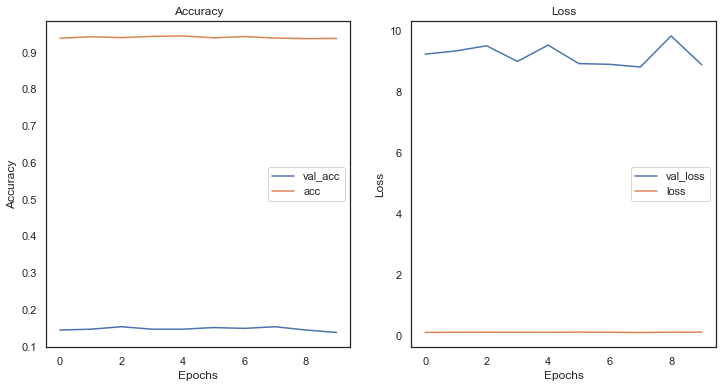

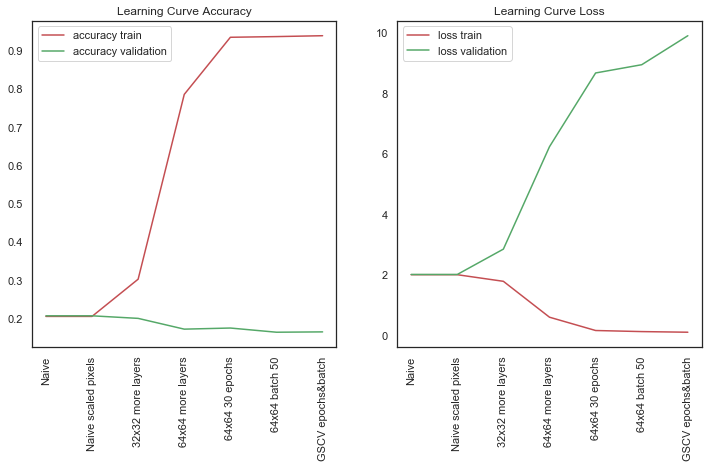

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788
0,64x64 30 epochs,0.934897,0.175671,0.172830,8.667449
0,64x64 batch 50,0.936685,0.164731,0.137188,8.939835
0,GSCV epochs&batch,0.938973,0.165625,0.116269,9.896316


In [87]:
df9=model_results(model_b, history6, 'GSCV epochs&batch', df9)
df9

After this change we see in general that accuracy train and validation stayed the same. Loss train went a bit down or stayed the same, loss validation went a bit up.

Changing the parameters in the definition of the function so I don't need to specify them again every time:

In [88]:
#Only changing default epochs and batch, everything else the same as above.
def statistic_results(model, trainX, trainy, epochs=best_epochs, batch=best_batch):
    accu_train=[]
    accu_val=[]
    loss_train=[]
    loss_val=[]
    for i in range(10):
        resu=fit_model(model, trainX,
                    trainy, epo=epochs, batch=batch)
        accu_train.append(round(resu.history['acc'][-1],5))
        accu_val.append(round(resu.history['val_acc'][-1],5))
        loss_train.append(round(resu.history['loss'][-1],5))
        loss_val.append(round(resu.history['val_loss'][-1],5))
        i+=1
    mean_acc_train=np.mean(accu_train)
    mean_acc_val=np.mean(accu_val)
    mean_loss_train=np.mean(loss_train)
    mean_loss_val=np.mean(loss_val)
    std_at=np.std(accu_train)
    std_av=np.std(accu_val)
    std_lt=np.std(loss_train)
    std_lv=np.std(loss_val)
    return ({'Mean_accuracy_train': mean_acc_train, 
             'Mean_accuracy_validation': mean_acc_val, 
             'Mean_loss_train': mean_loss_train, 
             'Mean_loss_validation': mean_loss_val,
             'Std_acc_train': std_at,
             'Std_acc_val': std_av,
             'Std_loss_train': std_lt,
             'Std_loss_val': std_lv})

### Grid Search Optimization Algorithm:

As we mentioned something that happens in Neural Networks is backpropagation.
<br>Backpropagation means comparing the results with y true and making adjustments to the weights. It is done by propagating the average error back through the network with the cost function guiding us.
<br>The process of adjustment consists of turning down previous neurons that have bad results and turning up the ones that gave good results.
<br>Who is responsible for updating the parameters is the optimization algorithm.

We can run again a GridSearch, but this time instead of trying different numbers of epochs and batch sizes, we will try different optimization algorithms.

Here is a list of them, and as we can see from the number of options, GridSearch is a good idea to shorten the time in trying all the different possible options:

- 'SGD'
- 'RMSprop'
- 'Adagrad'
- 'Adadelta'
- 'Adam' 
- 'Adamax' 
- 'Nadam'

The most popular and known optimization algorithms are SGD, RMS prop and Adam.
<br>RMS Prop is Root mean squared prop - it slows down learning in one direction and speeds it up in another one, based on in which direction we want to learn faster. On each iteration it uses exponentially weighted average of the squares of the derivatives.
<br>SGD stands for Stochastic Gradient Descent - works like gradient descent but SGD randomly picks one data point from the whole data set at each iteration to reduce the computations enormously. Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
<br>Adam: adaptive moment estimation - combines the benefits of SGD and RMSProp. It has has a different learning rate for each weight.

We already have the function to create the model, and the X and Y we set before are the same. We just need to change the grid for the search of the parameters.

In [89]:
"""
# create model
model = KerasClassifier(model=create_model(), 
                        loss="sparse_categorical_crossentropy", 
                        epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


'\n# create model\nmodel = KerasClassifier(model=create_model(), \n                        loss="sparse_categorical_crossentropy", \n                        epochs=best_epochs, batch_size=best_batch)\n# define the grid search parameters\noptimizer = [\'SGD\', \'RMSprop\', \'Adagrad\', \'Adadelta\', \'Adam\', \'Adamax\', \'Nadam\']\nparam_grid = dict(optimizer=optimizer)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n#'

In [90]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#"""

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n#'

In [91]:
#best_params=grid_result.best_params_
#best_params

In [92]:
#best_opti=best_params['optimizer']
#best_opti

Defining as `best_opti` the parameter found by the grid search: Adam.

In [93]:
### Just for now let me add this so we don't have to redo the search
best_opti='Adam'

Creating a new model with the selected optimizer algorithm:

In [94]:
model_d=create_model(optimizer=best_opti)

In [95]:
history7 = fit_model(model_d, train_img64, train_y,
                    epo=best_epochs,
                    batch=best_batch)

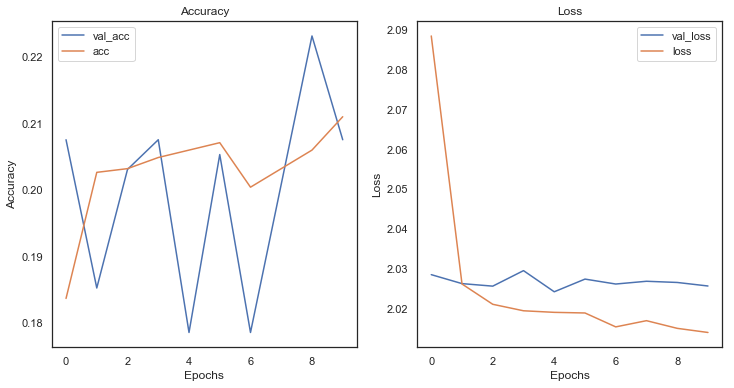

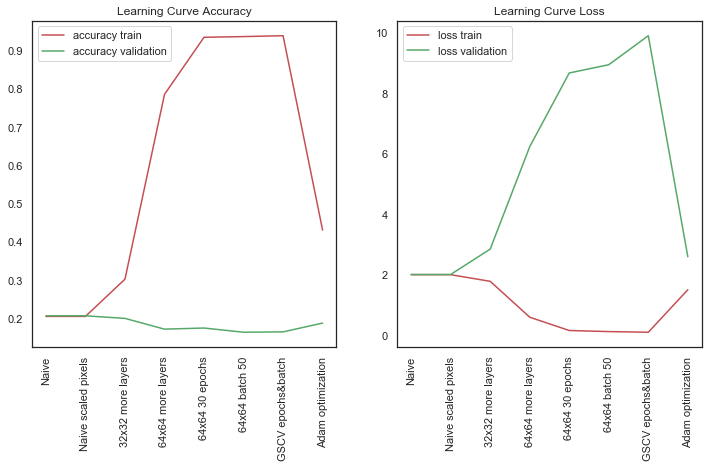

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788
0,64x64 30 epochs,0.934897,0.175671,0.172830,8.667449
0,64x64 batch 50,0.936685,0.164731,0.137188,8.939835
0,GSCV epochs&batch,0.938973,0.165625,0.116269,9.896316
0,Adam optimization,0.431435,0.188616,1.518056,2.602201


In [96]:
df9=model_results(model_d, history7, 'Adam optimization', df9)
df9

Now we finally see the accuracy of the validation set go up, even if the accuracy of the train went down.
<br>We also finally see the loss of the validation set plummet, even if the loss of the train went slightly up.
<br>Even if this decrease is not positive per se, it is good in general because we want the metrics of both validation and train to be similar, that is what is indicating that we are not overfitting.

### Grid Search Learning Rate

Learning rate is a parameter of the optimization algorithm that we can tune.
The learning rate defines the extent to update the weight at the end of each batch.
<br>We are going to do a grid search over learning rates of: [0.001, 0.01, 0.1, 0.2, 0.3]

In [97]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
#"""

'\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n\n#set X and Y\nX=train_img64\nY=train_y\n#'

In [98]:
"""
# create model
model = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", 
                        optimizer="Adam", epochs=20, batch_size=20, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(optimizer__learning_rate=learn_rate)#, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""

'\n# create model\nmodel = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", \n                        optimizer="Adam", epochs=20, batch_size=20, verbose=0)\n# define the grid search parameters\nlearn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]\nparam_grid = dict(optimizer__learning_rate=learn_rate)#, optimizer__momentum=momentum)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n#'

In [99]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
 #   """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n #   '

Let us print out just the best learning rate and momentum:

In [100]:
#best_params=grid_result.best_params_
#best_params

In [101]:
#best_rate=best_params['optimizer__learning_rate']
#best_rate

In [102]:
best_rate=0.001

Next we will define the optimizer as Adam with the parameters selected by the Grid Search, and then create a model, fit it and preview the results.

In [103]:
optimizer = tf.keras.optimizers.Adam(learning_rate=best_rate)

In [104]:
model_e=create_model(optimizer=optimizer)

In [105]:
history8= fit_model(model_e, train_img64, train_y,
                     epo=best_epochs,batch=best_batch)

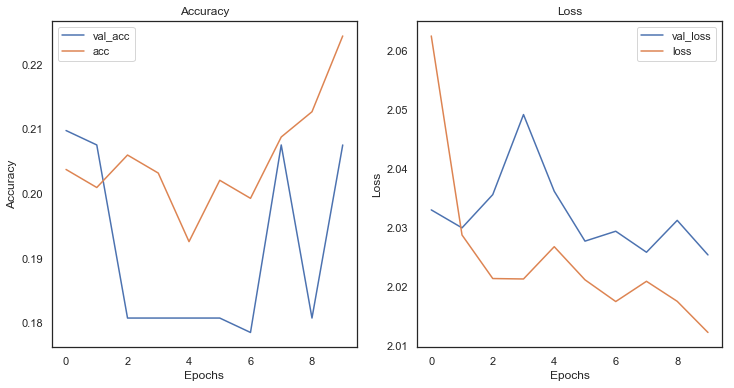

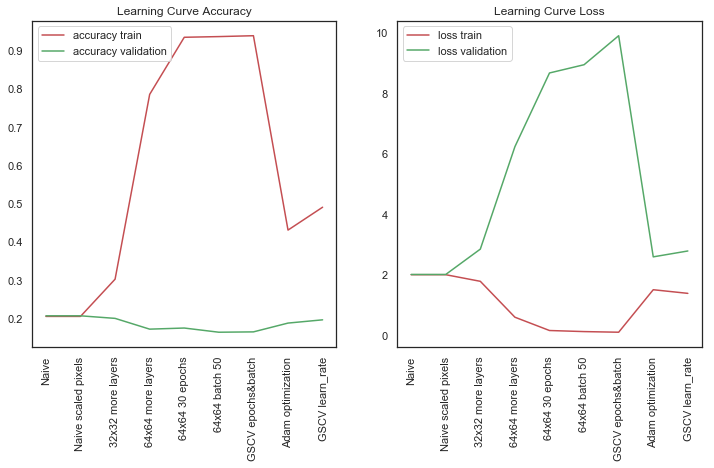

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788
0,64x64 30 epochs,0.934897,0.175671,0.172830,8.667449
0,64x64 batch 50,0.936685,0.164731,0.137188,8.939835
0,GSCV epochs&batch,0.938973,0.165625,0.116269,9.896316
0,Adam optimization,0.431435,0.188616,1.518056,2.602201
0,GSCV learn_rate,0.491177,0.197098,1.398136,2.796160


In [106]:
df9=model_results(model_e, history8, 'GSCV learn_rate', df9)
df9

We start to see again a slight improvement in the metrics of train set, and a slight worsening of the metrics of the validation, but nothing major.
<br>We will take steps later to drastically decrease the overfit, but for now we will keep tuning more parameters with Grid Searches.

### Grid Search for Neuron Activation Function

#### Changing activation functions and optimizations:
Some of the options for activation functions are:
- relu
- swish
- softmax
- leaky relu
- sigmoid
<br>The activation function is the one that connects our summed inputs into an output.
That output is then passed on to other nodes in other hidden layers, or as an end product in the output layer 

In simpler terms what it does is that it translates the probability calculated by the model into the label of an actual class. An image might have a 60, 70 or 80% chance to belong to a class, which needs to be translated into the fact that the image belongs to that class, 1, (or it doesn't, 0, in case of lose percentages below 50%).
<br>Sigmoid is the original one, and the other ones are all different adaptations on it, to solves issues the occurr with sigmoid either at large values, or with the derivative around zero.
<br>For multiclass classifications the appropriate one for the last layer is softmax, but we will tune the other ones for the previous layers of the model.

In [107]:
# Function to create model, required for KerasClassifier
def create_model_CV(activation):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(10, (3, 3), activation=activation,
                        input_shape=(64,64,3)))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(10, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(20, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

 # Compile model
    model.compile(loss='sparse_categorical_crossentropy', 
                   optimizer=optimizer, metrics=['accuracy'])
    return model

In [108]:
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y

In [109]:
"""
# create model
model = KerasClassifier(model=create_model_CV, epochs=20, batch_size=20)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 
              'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""

"\n# create model\nmodel = KerasClassifier(model=create_model_CV, epochs=20, batch_size=20)\n# define the grid search parameters\nactivation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', \n              'hard_sigmoid', 'linear']\nparam_grid = dict(model__activation=activation)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n#"

In [110]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n#    '

Best activation function is:

In [111]:
#best_params=grid_result.best_params_
#best_params

In [112]:
#best_function=best_params['model__activation']
#best_function

Defining as `best_function` the function selected by the Grid Search: 'relu'.

In [113]:
best_function='relu'

Creating the model, fitting it and viewing results.

In [114]:
model_f=create_model(activation=best_function, optimizer=optimizer)

In [115]:
history9= fit_model(model_f, train_img64, train_y,
                     epo=best_epochs, batch=best_batch)

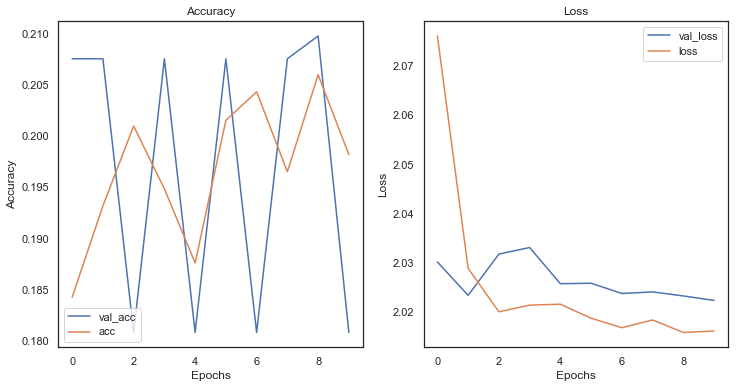

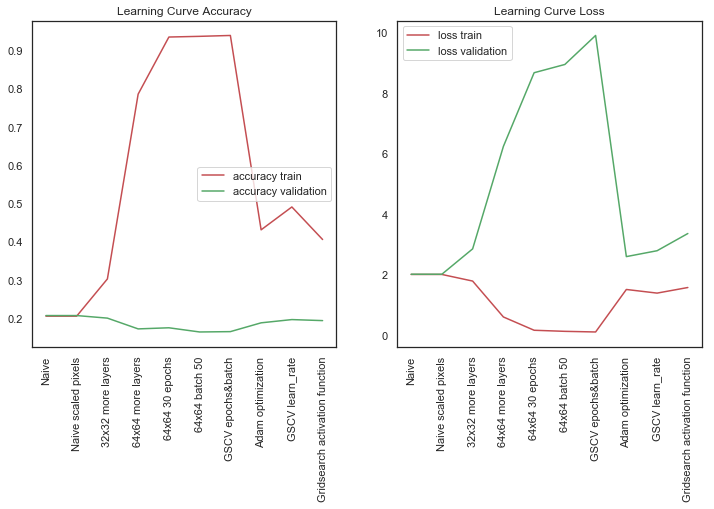

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788
0,64x64 30 epochs,0.934897,0.175671,0.172830,8.667449
0,64x64 batch 50,0.936685,0.164731,0.137188,8.939835
0,GSCV epochs&batch,0.938973,0.165625,0.116269,9.896316
0,Adam optimization,0.431435,0.188616,1.518056,2.602201
0,GSCV learn_rate,0.491177,0.197098,1.398136,2.796160
0,Gridsearch activation function,0.406140,0.194417,1.582959,3.363955


In [116]:
df9=model_results(model_f, history9, 'Gridsearch activation function', df9)
df9

We see the results staying more or less the same, sometimes with a slight improvement for the validation set, sometimes not, but in any case the difference is small from the previous model.

### Grid Search number of neurons:

Next we are going to perform a grid search to find the beset number of neurons for the first 4 layers of our CNN. <br>The last layer is set by the number of classes that we have, in our case 9.
<br>In general the more neurons I have the more finely and granularly I can approximate the function.
<br>We just have to ifnd the right amount that will not lead us to overfit even more.
<br>For this grid search we have to slightly modify our `create_model` function:

In [117]:
# Function to create model, required for KerasClassifier
def create_model_neurons(neurons):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neurons, (3, 3), activation=best_function,
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(neurons, (4, 4), activation=best_function))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(neurons, (3, 3), activation=best_function))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation=best_function))
    model.add(layers.Dense(9, activation=best_function))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_opti,
              metrics=['acc'])
    return model

Fixing random seed and defining X and Y:

In [118]:
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
#set X and Y
X=train_img64
Y=train_y

As usual we comment out the part of the GridSearch to let our code run faster but the code is left if anybody wanted to run the same search again, with different parameters or different data input.
The numbers of neurons we chose for our search are: [1, 2, 3, 5, 10, 15]

In [119]:
"""
# create model
model = KerasClassifier(model=create_model_neurons, epochs=30, batch_size=15, verbose=0)
# define the grid search parameters
neurons = [1, 2, 3, 5, 10, 15]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

'\n# create model\nmodel = KerasClassifier(model=create_model_neurons, epochs=30, batch_size=15, verbose=0)\n# define the grid search parameters\nneurons = [1, 2, 3, 5, 10, 15]\nparam_grid = dict(model__neurons=neurons)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n#'

In [120]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n#    '

In [121]:
#results=grid_result.best_params_
#results

In [122]:
#best_neurons=results['model__neurons']
#best_neurons

Selecting the best number of neurons that the search found:

In [123]:
best_neurons=5

Next creating our model, fitting it and getting results:

In [124]:
#creating the model
model_g=create_model(activation=best_function, optimizer=optimizer,
                     neur1=best_neurons)

In [125]:
#fitting the model and saving the history
history10 = fit_model(model_g, train_img64,train_y,
                     epo=best_epochs,batch=best_batch)

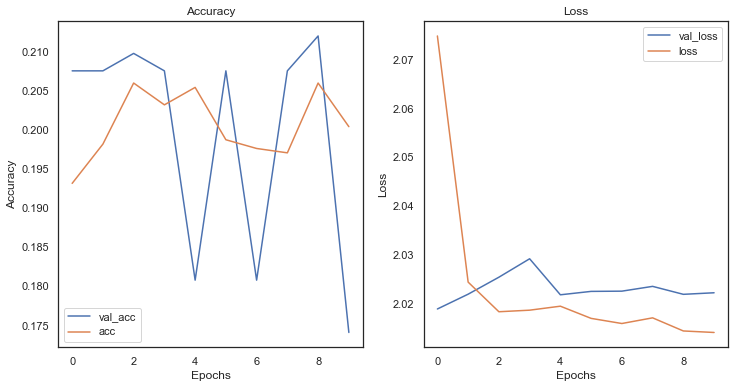

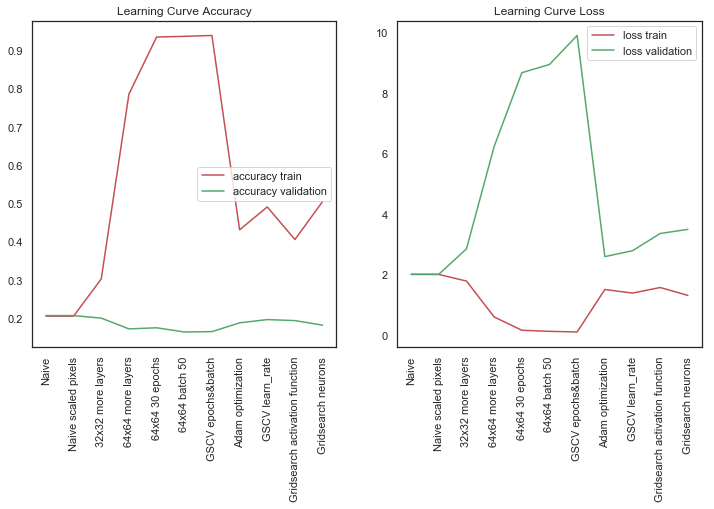

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788
0,64x64 30 epochs,0.934897,0.175671,0.172830,8.667449
0,64x64 batch 50,0.936685,0.164731,0.137188,8.939835
0,GSCV epochs&batch,0.938973,0.165625,0.116269,9.896316
0,Adam optimization,0.431435,0.188616,1.518056,2.602201
0,GSCV learn_rate,0.491177,0.197098,1.398136,2.796160
0,Gridsearch activation function,0.406140,0.194417,1.582959,3.363955


In [126]:
#storing our results in the dataframe and viewing
df9=model_results(model_g, history10, 'Gridsearch neurons', df9)
df9

On average at this point we see a decrease in the metrics for the train, and an increase for the validation set.
<br>The model is moving away form overfitting, and we will take the next steps specifically for this purpose.

## Tuning

Now that we selected all the best parameters for our model, there is some more tuning that we can do in particular to make sure that our model will not overfit the data.
This is achieved with regularization and dropout layers.

### Regularization

Regularization is commonly used when the model is overfitting the data.
<br>The main idea of regularization therefore is to penalize in some way a model that is too complex, that will tend to overfit the data.
<br>L1 regularization just adds one parameter, is not commonly used in Neural Networks.
<br>L2 on the other hand, also called "weight decay", makes the weights smaller, penalizing especially the largest weights, in a way forcing the model to be simplified.
<br>Now we are going to redefine the model adding the regularization term, L2:

In [127]:
model_h = models.Sequential()
model_h.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function))
model_h.add(layers.MaxPooling2D((2, 2)))
    
model_h.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function
                         ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))
model_h.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function
                          ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))

model_h.add(layers.Flatten())
model_h.add(layers.Dense(32, activation=best_function 
                       ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.Dense(9, activation='softmax'))

# Compile model
model_h.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])


Again fitting the model and saving the results:

In [128]:
history11 = fit_model(model_h, train_img64,train_y, epo=best_epochs,batch=best_batch)

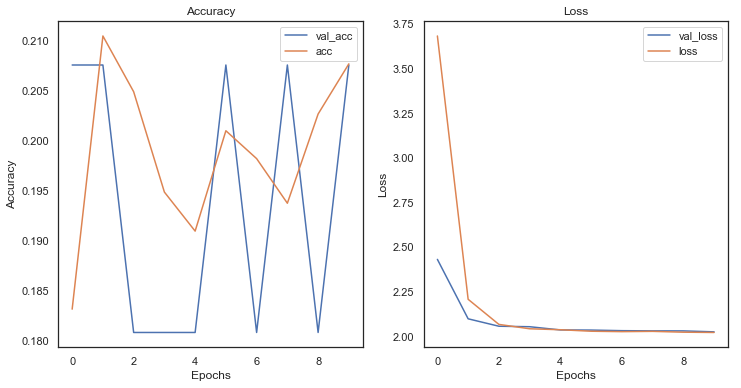

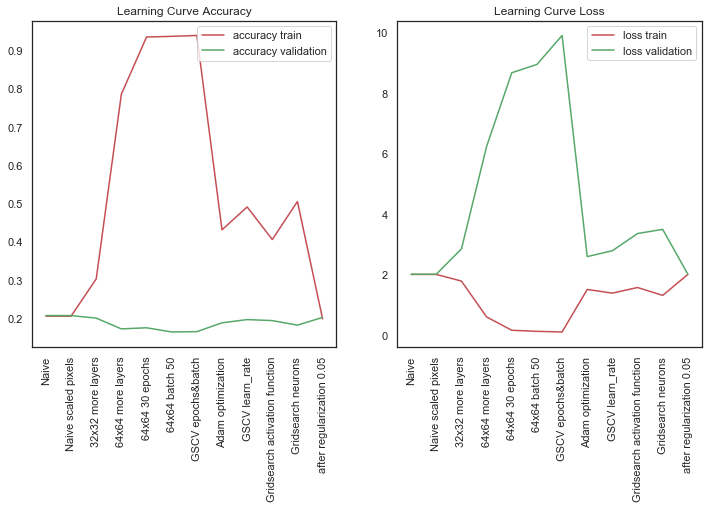

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788
0,64x64 30 epochs,0.934897,0.175671,0.172830,8.667449
0,64x64 batch 50,0.936685,0.164731,0.137188,8.939835
0,GSCV epochs&batch,0.938973,0.165625,0.116269,9.896316
0,Adam optimization,0.431435,0.188616,1.518056,2.602201
0,GSCV learn_rate,0.491177,0.197098,1.398136,2.796160
0,Gridsearch activation function,0.406140,0.194417,1.582959,3.363955


In [129]:
df9=model_results(model_h, history11, 'after regularization 0.05', df9)
df9

We tried also regularization parameters L2=0.005, L2=0.01, but the best value turned out to be L2=0.05, and we have not included the other ones for brevity.
<br>We see finally the model not overfitting, with the accuracy and loss being around the same values for train and validation.
<br>Unfortunately on average these values after regularization are around 20% for accuracy and around 2 for loss.

#### Dropout Regularization

Dropout regularization is another technique used to avoid the model overfitting the training data, and performing poorly on new data.
<br>The main idea is that the model should not rely heavily on any specific part of the data, because it could become oversensitive not to real trends and characteristic of the data, but to its noise.
<br>This is achieved with dropout layers, which force the model to block out some nodes, by setting their weights to zero.
<br>The shut off neurons force the model to learn using other neurons and other paths, for the model to not rely heavily on certain paths.
<br>We can set the dropout rate, which specifies the fraction of units to stop. It is usually between 0.2 and 0.5. We are going to run a grid search for this as well, to find the best rate, spanning the values [0.0, 0.3, 0.5, 0.7, 0.9].
<br>Another parameter that we can set is the weight constraint. This can be set so that the magnitude of all the weights in a layer have to be below the set value, it has the same principle of avoiding the model to rely strongly on certain parts of the network versus others.
<br>The weight constraint we are going to input in our Grid Search are: [1.0, 2.0, 3.0, 4.0, 5.0]


In [130]:
# Function to create model, required for KerasClassifier
def create_model_drop(dropout_rate, weight_constraint):

    model = models.Sequential()
    model.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function,
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
# First Dropout layer 
#    model.add(layers.Dropout(dropout_rate)    
    model.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function,
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
              
# Second Dropout layer 
    model.add(layers.Dropout(dropout_rate))
            

    model.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function, 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2))) 
              
# Third Dropout layer 
    model.add(layers.Dropout(dropout_rate))            

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=best_function, 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
              
# Fourth Dropout layer 
    model.add(layers.Dropout(dropout_rate))               
              
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
    return model

In [131]:
"""
# create model
model = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, 
                  model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""

'\n# create model\nmodel = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)\n# define the grid search parameters\nweight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]\n#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]\ndropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]\nparam_grid = dict(model__dropout_rate=dropout_rate, \n                  model__weight_constraint=weight_constraint)\n#param_grid = dict(model__dropout_rate=dropout_rate)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n#'

In [132]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))#    
#    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))#    \n#    '

In [133]:
#best_params=grid_result.best_params_
#best_params

In [134]:
#best_drop=best_params['model__dropout_rate']
#best_drop

In [135]:
best_drop=0.5

In [136]:
#best_weight_const=best_params['model__weight_constraint']
#best_weight_const

In [137]:
best_weight_const=3.0

Now that it is clear from the grid search what is the best drop out rate let us create our model with it and see the results in comparison to the other models.

In [138]:
model_i = models.Sequential()
model_i.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function,
                        input_shape=(64, 64, 3)))
model_i.add(layers.MaxPooling2D((2, 2)))
    
model_i.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function,
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_i.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
model_i.add(layers.Dropout(best_drop))
            
model_i.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function, 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_i.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
model_i.add(layers.Dropout(best_drop))            

model_i.add(layers.Flatten())
model_i.add(layers.Dense(32, activation=best_function, 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model_i.add(layers.Dense(9, activation='softmax'))

# Compile model
model_i.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
              

Fitting the model and getting results:

In [139]:
history12 = fit_model(model_i, train_img64,train_y,
                     epo=best_epochs,batch=best_batch)

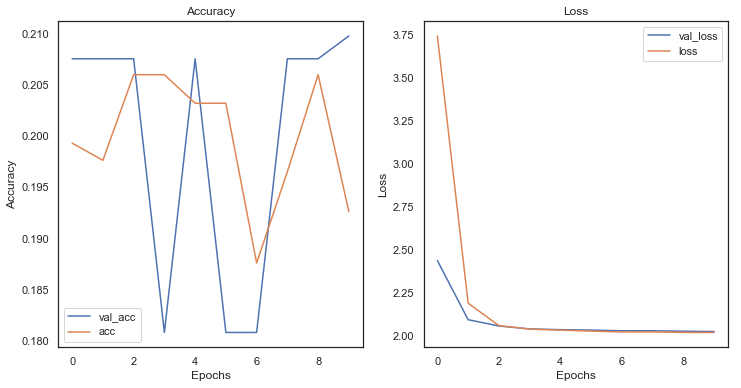

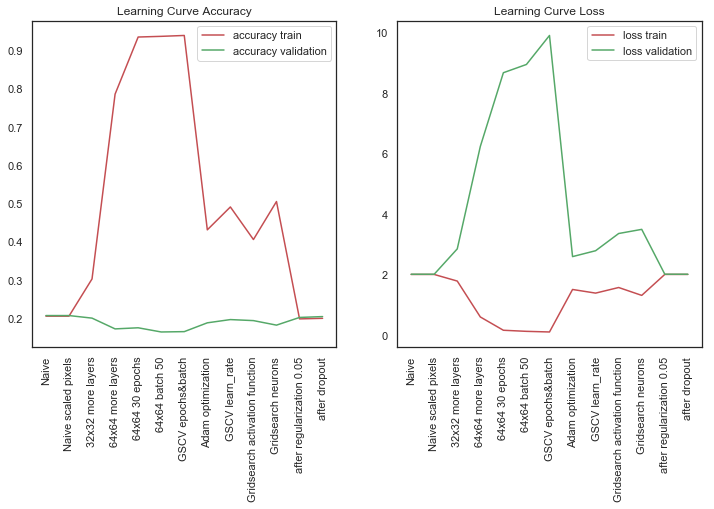

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.206030,0.207590,2.013618,2.021507
0,Naive scaled pixels,0.206030,0.207590,2.013570,2.021085
0,32x32 more layers,0.303239,0.200893,1.795509,2.857512
0,64x64 more layers,0.785764,0.172769,0.611546,6.235788
0,64x64 30 epochs,0.934897,0.175671,0.172830,8.667449
0,64x64 batch 50,0.936685,0.164731,0.137188,8.939835
0,GSCV epochs&batch,0.938973,0.165625,0.116269,9.896316
0,Adam optimization,0.431435,0.188616,1.518056,2.602201
0,GSCV learn_rate,0.491177,0.197098,1.398136,2.796160
0,Gridsearch activation function,0.406140,0.194417,1.582959,3.363955


In [140]:
df9=model_results(model_i, history12, 'after dropout', df9)
df9

On average we saw at this point all the metrics staying more or less the same.
<br>We are not seeing overfitting anymore but the accuracy or loss have not improved either.
<br>Next we are going to select our best model and making some predictions.

### Best model

The model that we saw on average perform best is the one we created right after tuning the number of neurons, model g.

<br>This model has the following parameters: 
<br>activation function = relu for each layer except last one softmax
<br>optimizer = Adam with learning rate 0.001
<br>neurons - 5 for each layer expect the last one in which they are 9

This model while still showing some overfitting has an accuracy for the validation set that is overall in the higher end of what we have seen througout our anaysis, around 20%, but was able to achieve an accuracy for the train between 60% and 80%.
<br>In terms of loss our final model has a mean of around 1 for the train and around 6 for the validation set.
<br>These are not the best results overall for the loss but we feel like they fall into a reasonable range, while staying close in value for train and test, and we decided to give more importance to the accuracy over the loss, since it gives a better sense of the performance of the model for our purposes.

### Evaluate the model:

First let us take a look at the results obtained by fitting the model 10 times and calculating the means of the metrics:

In [141]:
stats=statistic_results(model_g, train_img64,train_y)
stats

{'Mean_accuracy_train': 0.8366830000000001,
 'Mean_accuracy_validation': 0.17009100000000002,
 'Mean_loss_train': 0.484336,
 'Mean_loss_validation': 8.817823,
 'Std_acc_train': 0.031382820794186125,
 'Std_acc_val': 0.005628604533985308,
 'Std_loss_train': 0.07782491955665616,
 'Std_loss_val': 1.2759766758060274}

To evaluate the train we will use the `.evaluate` method to calculate the loss and accuracy, both on the train and on the test set, which so far we haven't touched, it is therefore unseen data.

#### On the train:

In [142]:
train_loss, train_acc= model_g.evaluate(train_img64, train_y)

print('Train Accuracy:', round(train_acc,3), '\nTrain Loss:', round(train_loss,3))

70/70 [==============================] - 1s 16ms/step - loss: 2.3850 - acc: 0.7325
Train Accuracy: 0.732 
Train Loss: 2.385


#### On the test:

In [143]:
test_loss, test_acc= model_g.evaluate(test_img64, test_y)

print('Test Loss:', round(test_loss,3), '\nTest Accuracy:', round(test_acc,3))

4/4 [==============================] - 0s 26ms/step - loss: 18.0913 - acc: 0.1102
Test Loss: 18.091 
Test Accuracy: 0.11


Next to make our results even more reliable we will create a function that evaluates the model 10 times, and calculates the mean and standard deviation, for the accuracy and loss, for train and test set.
<br>The results of this function are going to be always slightly different from the ones we see above, but because they are calculated as an average of 10 different calculations, we will take these as our final results rather then the ones above, that are much more unstable and fluctuate much more.

In [144]:
def evaluation_results(model, trainX, trainy,testX, testy,epochs=10, batch=50):
    accu_train=[]
    accu_test=[]
    loss_train=[]
    loss_test=[]
    for i in range(10):
        resu=fit_model(model, trainX,
                    trainy, epo=epochs, batch=batch)
        train_loss, train_acc= model_g.evaluate(trainX, trainy)
        test_loss, test_acc= model_g.evaluate(test_img64, test_y)
        accu_train.append(train_acc)
        accu_test.append(test_acc)
        loss_train.append(train_loss)
        loss_test.append(test_loss)
        i+=1
    mean_acc_train=np.mean(accu_train)
    mean_acc_test=np.mean(accu_test)
    mean_loss_train=np.mean(loss_train)
    mean_loss_test=np.mean(loss_test)
    std_at=np.std(accu_train)
    std_av=np.std(accu_test)
    std_lt=np.std(loss_train)
    std_lv=np.std(loss_test)
    return ({'Mean_accuracy_train': mean_acc_train, 
             'Mean_accuracy_test': mean_acc_test, 
             'Mean_loss_train': mean_loss_train, 
             'Mean_loss_test': mean_loss_test,
             'Std_acc_train': std_at,
             'Std_acc_test': std_av,
             'Std_loss_train': std_lt,
             'Std_loss_test': std_lv})

In [145]:
resu=evaluation_results(model_g, train_img64, train_y, test_img64, test_y)

4/4 [==============================] - 0s 15ms/step - loss: 22.5253 - acc: 0.1186


In [146]:
resu

{'Mean_accuracy_train': 0.7471639096736908,
 'Mean_accuracy_test': 0.12033898308873177,
 'Mean_loss_train': 2.7601509571075438,
 'Mean_loss_test': 20.941270637512208,
 'Std_acc_train': 0.015376527591008176,
 'Std_acc_test': 0.009127399413321887,
 'Std_loss_train': 0.1376553450572083,
 'Std_loss_test': 1.1417310042411393}

From these results we can draw our conclusion:
<br>This model reached an mean accuracy between 70% and 80% and a mean loss between 0 and 2 on the train.
<br>For the test set the results were an average accuracy between 15% and 20% on the test and loss on the test on average between 6 and 14.

Next let us view the confusion matrix obtained with this model:

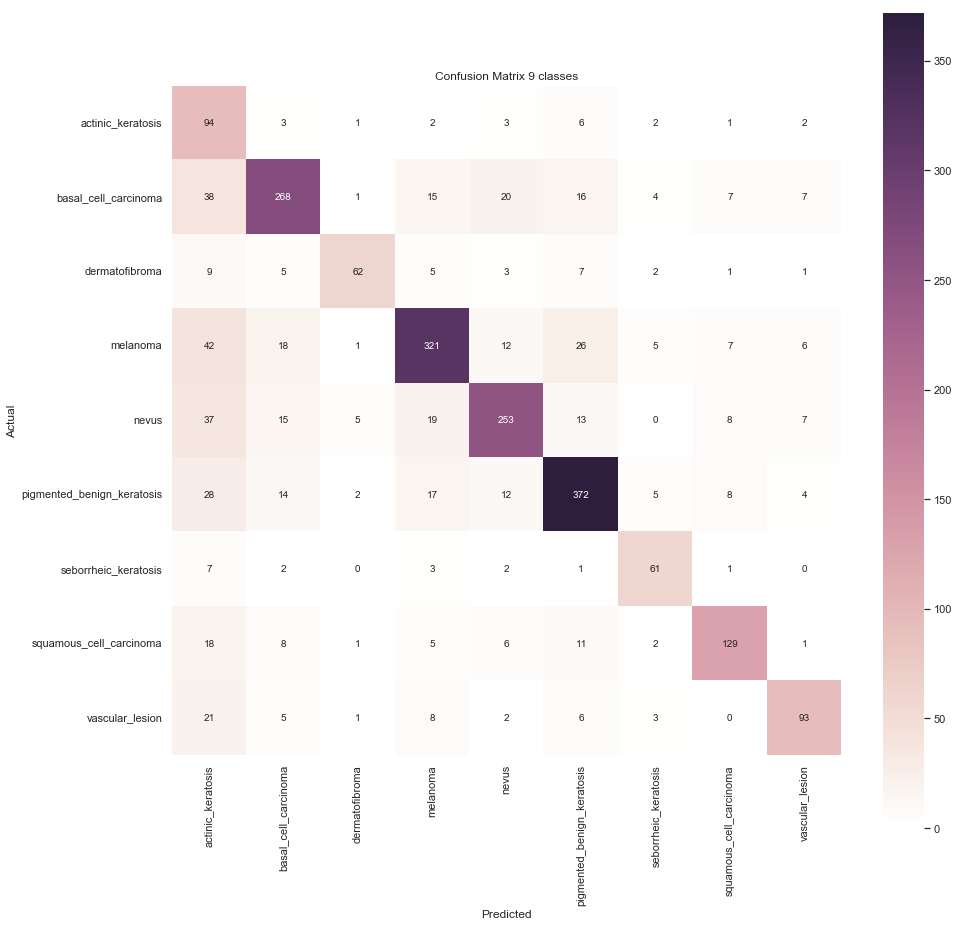

In [161]:
#First we get the predictions that will serve as input to the confusion matrix
y_pred_prob = model_g.predict(train_img64, verbose=0)
y_pred_clas =np.round(y_pred_prob).astype(int)
#calculating the confusion matrix and storing in a DataFrame for plotting
data = confusion_matrix(train_y,y_pred_clas.argmax(axis=1))
#defining the columns for the matrix with the names of the classes
cols=['actinic_keratosis','basal_cell_carcinoma','dermatofibroma','melanoma','nevus',
      'pigmented_benign_keratosis','seborrheic_keratosis','squamous_cell_carcinoma','vascular_lesion']
df_cm = pd.DataFrame(data, columns=cols, index = cols)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
#Plotting the multiclass confusion matrix
f, ax = plt.subplots(figsize=(15, 15))
#setting color palette
cmap = sns.cubehelix_palette(start=9, light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 10})
plt.title('Confusion Matrix 9 classes')
plt.show();

We can see from the confusion matrix that even if there were some errors in the classification, along the diagonal, which identifies the correctly identified images, there are some of the highest number on the chart.
<br>A further study could involve looking at each one of these values to determine which ones were "False Negatives" (when the class identified was benign, when the image was actually belonging to the 'cancerous' class) and which ones were False Positives (when it was identified as malignant and it was actually benign).
<br>But we will study this even more in depth next, redividing the images into two classes.

## Balancing the classes
One more way in which we can improve our model is by balancing the 9 classes, so that the model has a chance to learn equally about each one of them. This will hopefully make the model more flexible and precise to recognize each class.
<br>In order to do this we will generate new images from the ones we already have, by making slight changes like rotating and zooming.
<br>First we need to find out how many pictures for each class we need to generate.
<br>Let us preview the counts.

In [152]:
sums['Counts']

actinic_keratosis             114.0
basal_cell_carcinoma          376.0
dermatofibroma                 95.0
melanoma                      438.0
nevus                         357.0
pigmented_benign_keratosis    462.0
seborrheic_keratosis           77.0
squamous_cell_carcinoma       181.0
vascular_lesion               139.0
Name: Counts, dtype: float32

In [153]:
sums_test['Counts']

actinic_keratosis             16.0
basal_cell_carcinoma          16.0
dermatofibroma                16.0
melanoma                      16.0
nevus                         16.0
pigmented_benign_keratosis    16.0
seborrheic_keratosis           3.0
squamous_cell_carcinoma       16.0
vascular_lesion                3.0
Name: Counts, dtype: float32

**For the train**:The class with the highest number of images is pigmentes benign keratosis, which has 462 instances. This is the total that we want for every class.
<br>**For the test**: Most classes have 16 images, we have to increase the number of images only in the classes of sebhorrheic keratosis and vascular lesion.
<br>We will create a new column that tells us how many copies we need of each class.

In [154]:
sums['num_copies']=462-sums['Counts']
sums

,Counts,%,num_copies
actinic_keratosis,114.0,5.090000,348.0
basal_cell_carcinoma,376.0,16.790001,86.0
dermatofibroma,95.0,4.240000,367.0
melanoma,438.0,19.559999,24.0
nevus,357.0,15.940000,105.0
pigmented_benign_keratosis,462.0,20.629999,0.0
seborrheic_keratosis,77.0,3.440000,385.0
squamous_cell_carcinoma,181.0,8.080000,281.0
vascular_lesion,139.0,6.210000,323.0


In [156]:
sums_test['num_copies']=16-sums_test['Counts']
sums_test

,Counts,%,num_copies
actinic_keratosis,16.0,13.56,0.0
basal_cell_carcinoma,16.0,13.56,0.0
dermatofibroma,16.0,13.56,0.0
melanoma,16.0,13.56,0.0
nevus,16.0,13.56,0.0
pigmented_benign_keratosis,16.0,13.56,0.0
seborrheic_keratosis,3.0,2.54,13.0
squamous_cell_carcinoma,16.0,13.56,0.0
vascular_lesion,3.0,2.54,13.0


In [157]:
train_act_dir = 'dataskin/Train/actinic keratosis'
train_bas_dir = 'dataskin/Train/basal cell carcinoma'
train_der_dir = 'dataskin/Train/dermatofibroma'
train_mel_dir = 'dataskin/Train/melanoma'
train_nev_dir = 'dataskin/Train/nevus'
train_seb_dir = 'dataskin/Train/seborrheic keratosis'
train_scc_dir = 'dataskin/Train/squamous cell carcinoma'
train_vas_dir = 'dataskin/Train/vascular lesion'

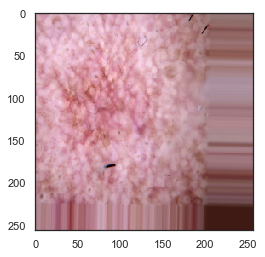

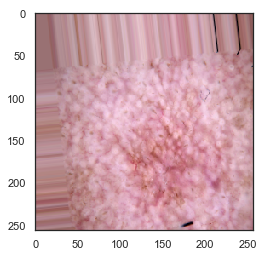

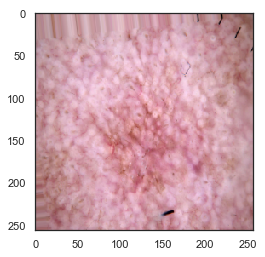

In [173]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=True)

#to preview an example
names = [os.path.join(train_act_dir, name) for name in os.listdir(train_act_dir)]
img_path = names[91]
img = load_img(img_path, target_size=(256, 256))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()


From this it's pretty clear how this tool works. Next we need to add the extra generated images to the same folders with the original ones to balance out the classes.

In [218]:
#from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(        
        rotation_range = 40,
        shear_range = 0.2,
        width_shift_range=0.2, 
        height_shift_range=0.2,
        zoom_range = 0.3,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))
import numpy as np
import os
from PIL import Image
#image_directory = r'C:Users---train/'
acti_dir = 'dataskin/Train/actinic keratosis'
#SIZE = 224
#SIZE=256
dataset = []
my_images = os.listdir(acti_dir)
for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(acti_dir + '/'+image_name)        
        image = Image.fromarray(image, 'RGB')        
#        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))
x = np.array(dataset)

In [223]:
# i is the number of copies I want to generate per image
i = 0
# Batch_size is going to be 174, with two copies per image
for batch in train_datagen.flow(x, batch_size=58,
                          save_to_dir= acti_dir,
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
# to make our model as flexible as possible we keep only two copies per image
    if i > 6:        
        break

In [221]:
i = 0
# Batch_size is going to be 174, with two copies per image
for batch in train_datagen.flow(x, batch_size=6,
#train_datagen.flow(x, batch_size=15,
                          save_to_dir= acti_dir,
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
# to make our model as flexible as possible we keep only two copies per image
    if i > 1:        
        break

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(        
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))
import numpy as np
import os
from PIL import Image
image_directory = r'C:Users---train/'
SIZE = 224
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(image_directory + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir= r'C:Users---Augmented-images',
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
    if i > 50:        
        break

Image data generator is imported from Keras for implementing data augmentation on the training data. Other modules like ‘os’, ‘numpy’, ‘io’, Image are imported for implementing the code. The augmentation techniques are then applied to each and every image which are later saved into the directory specified by the programmer. The “image_directory” takes the path for the original dataset, and the “size” determines the size of the images in the dataset. The “save_prefix” is used to name the augmented images and “save_format” determines the format of the augmented images, they can be jpeg, png, tiff, etc.,

The code when executed saves the images into a new folder names ‘Augmented-images’ the images are named ‘dr’ and saved in ‘JPEG’ format. This code can be used in many areas where the data is unclear or insufficient.  The ‘if’ loop is used to determine the number of times the ‘for’ loop needs to be iterated.

The augmented images can sometimes be unclear due to repeated processing. There are other techniques for denoising the images. But this is the easiest way of increasing the data without the probable case of overfitting the machine learning model.

The process of data augmentation provides diversity to the data and also makes the deep learning model robust. So that the model does not have to depend on only clear and correct data all the time.

# Changing to two classes: cancerous and bening<a id='2classes'></a>

As we mentioned, we want to also create a second model, that simply returns the information if the skin growth is cancerous or benign, and we will add some more metrics that better describe this type of binary problem.
<br>First we will work on the data, creating a separate folder 'binary' in which we will store the images divided into 2 classes instead of 9, 'benign' and 'cancerous'.
<br>This folder will still have the same division into train and test that the original data has.
<br>Some of the code below is commented out as we wanted to create the directory and copy the images only once, and not every time that the notebook is compiled, but a user that would want to do the same can uncomment and proceed with the code as is to create the same directories and subfolders.

First we will do this process for the train set, and subsequently for the test.

#### Train Set:
Creating the current directories where we can find the images divided into 9 classes:

In [ ]:
acti_dir = 'dataskin/Train/actinic keratosis'
basal_dir = 'dataskin/Train/basal cell carcinoma'
derma_dir = 'dataskin/Train/dermatofibroma'
mela_dir = 'dataskin/Train/melanoma'
nevus_dir = 'dataskin/Train/nevus'
pigm_dir = 'dataskin/Train/pigmented benign keratosis'
sebo_dir = 'dataskin/Train/seborrheic keratosis'
squa_dir = 'dataskin/Train/squamous cell carcinoma'
lesion_dir = 'dataskin/Train/vascular lesion'

Creating a new directory to store the images divided into only 2 classes:

In [ ]:
new_dir = 'dataskin/binary/'

Extracting information about number of images in each directory:

In [ ]:
imgs_acti = [file for file in os.listdir(acti_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images of actinic keratosis')
imgs_basal = [file for file in os.listdir(basal_dir) if file.endswith('.jpg')]
print('There are', len(imgs_basal), 'images of basal cell carcinoma')
imgs_mela = [file for file in os.listdir(mela_dir) if file.endswith('.jpg')]
print('There are', len(imgs_mela), 'images of melanoma')
imgs_squa = [file for file in os.listdir(squa_dir) if file.endswith('.jpg')]
print('There are', len(imgs_squa), 'images of squamous cell carcinoma')

imgs_derma = [file for file in os.listdir(derma_dir) if file.endswith('.jpg')]
print('There are', len(imgs_derma), 'images of dermatofibroma')
imgs_nevus = [file for file in os.listdir(nevus_dir) if file.endswith('.jpg')]
print('There are', len(imgs_nevus), 'images of nevus')
imgs_pigm = [file for file in os.listdir(pigm_dir) if file.endswith('.jpg')]
print('There are', len(imgs_pigm), 'images of pigmented benign keratosis')
imgs_sebo = [file for file in os.listdir(sebo_dir) if file.endswith('.jpg')]
print('There are', len(imgs_sebo), 'images of seborrheic keratosis')
imgs_lesion = [file for file in os.listdir(lesion_dir) if file.endswith('.jpg')]
print('There are', len(imgs_lesion), 'images of vascula lesion')

Code to create the new folder "binary":

In [ ]:
# Code to create the new folder 'binary'
#os.mkdir(new_dir)

Code to create paths to the subfolders:

In [ ]:
""" Code to create paths to subfolders
train_folder = os.path.join(new_dir, 'train')
train_benign = os.path.join(train_folder, 'benign')
train_cancerous = os.path.join(train_folder, 'cancerous')

test_folder = os.path.join(new_dir, 'test')
test_benign = os.path.join(test_folder, 'benign')
test_cancerous = os.path.join(test_folder, 'cancerous')
"""

Code to create the subfolders:

In [ ]:
""" Code to create subfolders

os.mkdir(train_folder)
os.mkdir(train_benign)
os.mkdir(train_cancerous)

os.mkdir(test_folder)
os.mkdir(test_benign)
os.mkdir(test_cancerous)
"""

We have to split the classes between benign and cancerous, so recall:
<br>Actinic keratosis, basal cell carcinoma, melanoma and squamous cell carcinoma are cancerous.
<br>Dermatofibroma, pigmented benign keratosis, nevus, seborrheic keratosis and vascular lesions are benign.
<br>As totals we except:

In [ ]:
total_benign=len(imgs_derma)+len(imgs_nevus)+len(imgs_pigm)+len(imgs_sebo)+len(imgs_lesion)
total_cancerous=len(imgs_acti)+len(imgs_basal)+len(imgs_mela)+len(imgs_squa)
print(f'total bening {total_benign}, total cancerous {total_cancerous}')

As we can tell the number of images for cancerous and benign in the train set are similar, so we don't need to worry about a class imbalance in our case, but the code is also included on how to deal with class imbalance [here](#imbalance_cell).

Below is the code to copy images from the 5 benign classes into the new folder 'benign':

In [ ]:
""" Code to copy images from 5 folders into new folder 'benign'
imgs = imgs_derma
for img in imgs:
    origin = os.path.join(derma_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_nevus
for img in imgs:
    origin = os.path.join(nevus_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_pigm
for img in imgs:
    origin = os.path.join(pigm_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_sebo
for img in imgs:
    origin = os.path.join(sebo_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_lesion
for img in imgs:
    origin = os.path.join(lesion_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
    """ 

Checking the content of the 'benign' folder:

In [ ]:
train_benign_dir = 'dataskin/binary/train/benign'

imgs_benign = [file for file in os.listdir(train_benign_dir) if file.endswith('.jpg')]
print('There are', len(imgs_benign), 'images in train benign')

Moving on to the cancerous class:
<br>copying the images form the 4 folders into the one 'cancerous' folder.

In [ ]:
""" Code to copy images from 4 folders into new folder 'cancerous'
#train cancerous
imgs = imgs_acti
for img in imgs:
    origin = os.path.join(acti_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_basal
for img in imgs:
    origin = os.path.join(basal_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_mela
for img in imgs:
    origin = os.path.join(mela_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_squa
for img in imgs:
    origin = os.path.join(squa_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
    """

Checking the content:

In [ ]:
train_can_dir = 'dataskin/binary/train/cancerous'

imgs_canc = [file for file in os.listdir(train_can_dir) if file.endswith('.jpg')]
print('There are', len(imgs_canc), 'images in train cancerous')

### Diving in to 2 classes the Test Set:
Now we just need to repeat the same steps for the test.
<br>Creating the directories of the original images:

In [ ]:
acti_dir = 'dataskin/Test/actinic keratosis'
basal_dir = 'dataskin/Test/basal cell carcinoma'
derma_dir = 'dataskin/Test/dermatofibroma'
mela_dir = 'dataskin/Test/melanoma'
nevus_dir = 'dataskin/Test/nevus'
pigm_dir = 'dataskin/Test/pigmented benign keratosis'
sebo_dir = 'dataskin/Test/seborrheic keratosis'
squa_dir = 'dataskin/Test/squamous cell carcinoma'
lesion_dir = 'dataskin/Test/vascular lesion'

Checking the content:

In [ ]:
imgs_acti = [file for file in os.listdir(acti_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images of actinic keratosis')
imgs_basal = [file for file in os.listdir(basal_dir) if file.endswith('.jpg')]
print('There are', len(imgs_basal), 'images of basal cell carcinoma')
imgs_mela = [file for file in os.listdir(mela_dir) if file.endswith('.jpg')]
print('There are', len(imgs_mela), 'images of melanoma')
imgs_squa = [file for file in os.listdir(squa_dir) if file.endswith('.jpg')]
print('There are', len(imgs_squa), 'images of squamous cell carcinoma')

imgs_derma = [file for file in os.listdir(derma_dir) if file.endswith('.jpg')]
print('There are', len(imgs_derma), 'images of dermatofibroma')
imgs_nevus = [file for file in os.listdir(nevus_dir) if file.endswith('.jpg')]
print('There are', len(imgs_nevus), 'images of nevus')
imgs_pigm = [file for file in os.listdir(pigm_dir) if file.endswith('.jpg')]
print('There are', len(imgs_pigm), 'images of pigmented benign keratosis')
imgs_sebo = [file for file in os.listdir(sebo_dir) if file.endswith('.jpg')]
print('There are', len(imgs_sebo), 'images of seborrheic keratosis')
imgs_lesion = [file for file in os.listdir(lesion_dir) if file.endswith('.jpg')]
print('There are', len(imgs_lesion), 'images of vascula lesion')

Finding out total number of benign and cancerous images in the test set:

In [ ]:
total_benign=len(imgs_derma)+len(imgs_nevus)+len(imgs_pigm)+len(imgs_sebo)+len(imgs_lesion)
total_cancerous=len(imgs_acti)+len(imgs_basal)+len(imgs_mela)+len(imgs_squa)
print(f'total bening {total_benign}, total cancerous {total_cancerous}')

As we can see again the classes are pretty well balanced.
Next we will copy the images from the original 9 classes folders into the 'benign' folder for the test set.

In [ ]:
""" Code to copy images from 5 folders into new folder 'benign'
# test benign
imgs = imgs_derma
for img in imgs:
    origin = os.path.join(derma_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_nevus
for img in imgs:
    origin = os.path.join(nevus_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_pigm
for img in imgs:
    origin = os.path.join(pigm_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_sebo
for img in imgs:
    origin = os.path.join(sebo_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_lesion
for img in imgs:
    origin = os.path.join(lesion_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
    """

Checking the content

In [ ]:
test_benign_dir = 'dataskin/binary/test/benign'

imgs_test = [file for file in os.listdir(test_benign_dir) if file.endswith('.jpg')]
print('There are', len(imgs_test), 'images in test benign')

Copying the images into the 'cancerous' folder for the test set.

In [ ]:
""" Code to copy images from 4 folders into new folder 'cancerous'
#test cancerous
imgs = imgs_acti
for img in imgs:
    origin = os.path.join(acti_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_basal
for img in imgs:
    origin = os.path.join(basal_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_mela
for img in imgs:
    origin = os.path.join(mela_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_squa
for img in imgs:
    origin = os.path.join(squa_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
"""

Checking the content:

In [ ]:
test_can_dir = 'dataskin/binary/test/cancerous'

imgs_acti = [file for file in os.listdir(test_can_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images in test cancerous')

#### In the case of class imbalance:
<a id='imbalance_cell'></a>

If there was an imbalance between the classes we could balance them using augmentation, which consists in generating more data from the images we already have.
<br>If for example we had many more images of benign growths, we could generate more images form the ones we have of cancerous growths.
<br>This technique allows to rotate, shift, zoom and flip an image, to generate a slightly different one form the original, to be included in the data used to train our model.
<br>We include here the code to do so, if a user wanted to try this out, especially if, using a different dataset that was to be imbalanced, one wanted to balance it out.
<br>One of the next steps for our model is to balance out the 9 different classes, to improve the results of our previous model.
<br>We could do so using this code, producing more images for the less populated classes so that the model could learn to identify them all equally.

In [ ]:
"""
# If there is an imbalance re balance the classes with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=True)

#to preview an example
names = [os.path.join(train_benign, name) for name in os.listdir(train_benign)]
img_path = names[91]
img = load_img(img_path, target_size=(64, 64))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()
"""

### Importing again images, divided in two classes instead of 9:
We will import the images in the 64x64 size for both train and test:

In [ ]:
# Directory path
train_data_dir = 'dataskin/binary/train'
test_data_dir = 'dataskin/binary/test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Create the datasets
train_img_bin, train_lab_bin = next(train_gen)
test_img_bin, test_lab_bin = next(test_gen)

train_img_bin /= 255.
test_img_bin /= 255.

Let us look at the class indexes:

In [ ]:
train_gen.class_indices 

Exploring the dataset:

In [ ]:
# Explore your dataset again
m_train = train_img_bin.shape[0]
num_px = train_img_bin.shape[1]
m_test = test_img_bin.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_img_bin.shape))
print ("train_labels shape: " + str(train_lab_bin.shape))
print ("test_images shape: " + str(test_img_bin.shape))
print ("test_labels shape: " + str(test_lab_bin.shape))

Reshape the train and test labels:

In [ ]:
train_y_bin = np.reshape(train_lab_bin[:,0], (2239,1))
test_y_bin = np.reshape(test_lab_bin[:,0], (118,1))

### New Metrics: Recall and F1 score

Now that we have defined the problem in a different way, having two classes and therefore making it a binary problem, we can define and use different metrics to evaluate our models.
<br>In particular a metric that is very widely used in the medical field is recall, which tells us what percentage of the classes we are interested in were actually captured by the model.
<br>It is calculated as number of true positives identified by the model (true positive means the sample belonged to a class and we identified it correctly as belonging to that class) divided by the number of actual total positives (all the samples belonging to that class). <br>It gives us a sense of how many cases we identified correctly in a class compared to the total of that class.
<br>What brings down the recall is the number of positives that were not identified, called false negatives. In our case it would be when a skin anomaly was classified as benign, when it is actually cancerous.
<br>We want to obviously minimize these instances, even if it means the overall precision of the model is lower, we would rather identify more cancerous cases (even if some will turn out to be actually benign) rather than the other way around, since the risk is leaving untreated a patient that has a cancerous skin growth.
<br>At the same time we do not want our model to become overall very imprecise, the risk with high recall for the model is to identify all the cases as cancerous, which would leave us with no false negatives but with also very little accuracy of the model overall. 
<br>This is why we decided to pair the recall with another metric, F1.
<br>F1 is the harmonic mean of precision and recall.
<br>We will keep an eye on F1 which gives us an overall sense of the performance of the model (to make sure we are not getting an amazing recall while all the other metrics are plummeting) and we will keep looking at accuracy and loss also, as we have done before.

Let us define a few new functions to introduce these metrics and keep track of them:
<br>First a function to calculate recall and f1, fitting and predicting with the same model 10 times and taking the mean of the recall and f1.

In [ ]:
def calculate_metrics(model, trainX=train_img_bin, trainy=train_y_bin, epochs=10, batch=30):
    recs=[]
    f1s=[]
    for i in range(10):
        fit_model(model, trainX, trainy, epo=epochs, batch=batch)
    # predict probabilities
        y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
        y_pred_clas = (model.predict(trainX) > 0.5).astype("float")
        #Calculating recall
        recall = recall_score(trainy, y_pred_clas)
        #Calculating f1
        f1 = f1_score(trainy, y_pred_clas)
        #Appending results
        recs.append(recall)
        f1s.append(f1)
        i+=1
    #Calculating mean of f1 and recall
    recall_mean=np.mean(recs)
    f1_mean=np.mean(f1s)
        
    return recall_mean, f1_mean#, trainy, y_pred_clas

Next we defined a function to plot the confusion matrix, which shows us visually how many True positives and True Negatives (bottom right corner and top left corner) the model identified.
<br>It gives us also a sense of the cases that the model got wrong, plotting the false negatives on the bottom left, and the false positives on the top right.

In [ ]:
def conf_matrix(model,  title, trainX=train_img_bin, trainy=train_y_bin):
    seed = 42
    tf.random.set_seed(seed)
    y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
    y_pred_clas = (model.predict(trainX) > 0.5).astype("float")
    # confusion matrix
    cnm = confusion_matrix(trainy, y_pred_clas)
    # To Normalize
    cnm = cnm.astype('float') / cnm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cnm, annot=True, fmt='.2f', cmap="Oranges")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show(block=False)

We will cerate also a function similar to the one we defined before for the model results.
<br>It will plot the history of accuracy and loss of the model. Under that it will plot the learning curve for accuracy and loss, as we had before to track the progress as we tune our model.
<br>Lastly it will plot the learning curve of recall and f1 score, just like for the accuracy and loss, to be able to see how our models are doing in terms of those metric, every time that we change some of the parameters.

In [ ]:
def model_results_bin(model, results, model_name, df, 
                      trainX=train_img_bin, trainy=train_y_bin):
    #Plotting accuracy and loss over the epochs using our function
    visualize_training_results(results)
    #Extracting recall and f1 with our function 'calculate_metrics'
    recall, f1=calculate_metrics(model, trainX, trainy)
    df1 = pd.DataFrame({'Name': [model_name], 
                        'model':[model],
        'accuracy train': [round(results.history['acc'][-1],5)] ,
        'accuracy validation': [round(results.history['val_acc'][-1],5 )],
        'loss train': [round(results.history['loss'][-1],5)],
        'loss validation': [round(results.history['val_loss'][-1],5)],
        #Adding recall and f1 to the results of the dataframe 
        'recall': [recall] ,
        'f1': [f1]                      
                       })
    #Appending results to the general dataframe
    df=df.append(df1)
    #plotting subplots
    fig = plt.subplots(figsize=(12,6))
    #Plotting Learning curve accurcy
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
    #Plotting learning curve loss
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()
    plt.show()
    
    fig = plt.subplots(figsize=(12,6))
    #Plotting learning curve recall
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['recall']
    plt.plot(x, y, color='cyan')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Recall')
    plt.legend()
    #Plotting learning curve F1
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['f1']
    plt.plot(x, y, color='purple')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve F1')
    plt.legend()

    plt.show()
    
    return df

### Binary Models

#### Naive Model:

First building a very simple naive model with only one convolutional layer, that we will use as a baseline:

In [ ]:
naive_model = models.Sequential()
naive_model.add(layers.Conv2D(3, (3, 3), activation='sigmoid',
                        input_shape=(8 ,8,  3)))
naive_model.add(layers.MaxPooling2D((2, 2)))

naive_model.add(layers.Flatten())
naive_model.add(layers.Dense(1, activation='sigmoid'))

naive_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Creating an empty DataFrame to use to store the results:

In [ ]:
df=pd.DataFrame()

Importing images with a lower resolution (8x8) for the naive model:

In [ ]:
# Directory path
train_data_dir = 'dataskin/binary/train'
test_data_dir = 'dataskin/binary/test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(8, 8), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=2239)

# Create the datasets
train_img_bin8, train_lab_bin8 = next(train_gen)
test_img_bin8, test_lab_bin8 = next(test_gen)
#Normalizing the pixel values
train_img_bin8 /= 255.
test_img_bin8 /= 255.
#Reshaping the labels array
train_y_bin8 = np.reshape(train_lab_bin8[:,0], (2239,1))
test_y_bin8 = np.reshape(test_lab_bin8[:,0], (118,1))

Fitting the model:

In [ ]:
naive_hist = fit_model(naive_model, train_img_bin8, train_y_bin8 , val_split=0.3, verbose=1)

In [ ]:
df=model_results_bin(results=naive_hist, model_name='Naive binary model', df=df, 
                     model=naive_model, trainX=train_img_bin8, trainy=train_y_bin8)
df_print=df.drop('model', axis=1)

Just like previously, there is not much to see in the last 4 plots but once we start building those learning curves they will be very useful to track our progress.

### Improving the model:

Next we are going to add more layers to our model.
To be able to create models more easily, we will define again a `create_model` function for the binary case.

In [ ]:
def create_model_bin(input_shape=(64, 64, 3), activation='relu', metrics=['acc'],
                optimizer='adam', neur1=10, neur2=20):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(1, activation=activation))

# Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=metrics)
    return model

Creating the first improved model:

In [ ]:
model_bina=create_model_bin()

Fitting the model:

In [ ]:
hist_bin1=fit_model(model_bina, train_img_bin, train_y_bin)

Generating, saving and plotting results:

In [ ]:
df=model_results_bin(model_bina, hist_bin1,'More layers',df)
# Creating another DataFrame without the 'code' column for esthetic and clarity reasons
df_print=df.drop('model', axis=1)
df_print

The results we are going to obtain are not always the same, due to the stochastic nature of the Neural Networks and also to the randomness of the validation split.
<br>Because of this we are not going to comment the results after every step of tuning, since we saw the results changing drastically at every re-run.
<br>We are instead going to comment exahustively on all of them at the end of the tuning process, while explaining the method we decided to use for the selection of the best model, given the great instability of the results we are seeing.

## Re tuning of the parameters
We are going to go through very similar steps like the ones we took before, but this time tuning the binary model.
We will make an extensive use of GridSearch to be able to test multiple values for the hyperparameters.
<br>As before, the code for the search itself is commented out, and the result of the search is saved, to decrease running time but at the same time leaving the code available to be uncommented and ran again.

### Grid Search batch size and epochs:

Just as we did before we are going to run a grid search to find the best number of epochs and batch size.
<br>Also here the code has been commented out but can be used to run the search again with different parameters.

In [ ]:
"""
# Use scikit-learn to grid search the batch size and epochs
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_bin())
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

The result we obtained for best batch size and epochs are:

In [ ]:
#best_batch=best_params['batch_size']
#best_epochs=best_params['epochs']
best_batch=100
best_epochs=50

Fitting the model with those parameters:

In [ ]:
hist_bin2=fit_model(model_bina, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

Saving and plotting results:

In [ ]:
df=model_results_bin(model_bina, hist_bin2, 'best epochs&batch', df)
df_print=df.drop('model', axis=1)
df_print

### Grid Search for optimization algorithm:

Next we are going to run a grid search to choose the best optimization algorithm:

In [ ]:
"""
# create model
model = KerasClassifier(model=create_model_bin(), 
                        epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

The best optimizer turned out to be:

In [ ]:
#best_opti=best_params['optimizer']
best_opti='RMSprop'

Creating the model with our new optimizer, fitting it and getting results:

In [ ]:
model_binb=create_model_bin(optimizer=best_opti)

In [ ]:
hist_bin3=fit_model(model_binb, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

In [ ]:
df=model_results_bin(model_binb, hist_bin3, 'RMS prop', df)
df_print=df.drop('model', axis=1)
df_print

### RMSProp Grid Search Learning Rate and Momentum:
Once again we are tuning the parameters learning rate and momentum for our optimizer, using a GridSearch.

In [ ]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_bin(), loss="binary_crossentropy", 
                        optimizer="RMSprop", epochs=20, batch_size=20, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

Best rate and best momentum are:

In [ ]:
#best_rate=best_params['optimizer__learning_rate']
best_rate=0.01

In [ ]:
#best_momentum=best_params['optimizer__weight_decay']
best_momentum=0.6

Setting up our optimizer with the newfound parameters:

In [ ]:
optimizer_rms = tf.keras.optimizers.RMSprop(learning_rate=0.1, 
                                    momentum=0.6)

Creating our model, fitting it and getting results:

In [ ]:
model_binc2=create_model_bin(optimizer=optimizer_rms)

In [ ]:
hist_bin42=fit_model(model_binc2, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

In [ ]:
df=model_results_bin(model_binc2, hist_bin42, 'RMS best mom&LR', df)
df_print=df.drop('model', axis=1)
df_print

### Grid Search Neuron activation function

Next we are going to tune the Neuron activation function, we are going to do again a GridSearch to try different ones: ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

In [ ]:
"""
# Function to create model, required for KerasClassifier
def create_model_CV_bin(activation='relu'):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(10, (3, 3), activation=activation,
                        input_shape=(64,64,3)))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(10, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(20, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(1, activation=activation))

 # Compile model
    model.compile(loss='binary_crossentropy', 
                   optimizer=optimizer_rms, metrics=['accuracy'])
    return model
    """

In [ ]:
"""
# create model
model = KerasClassifier(model=create_model_CV_bin, epochs=20, batch_size=20)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 
              'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

What the search identified as the best activation function:

In [ ]:
#best_function=best_params['model__activation']
best_function='sigmoid'

Next creating the model, fitting it, saving and plotting results.

In [ ]:
model_bind=create_model_bin(activation=best_function, optimizer=optimizer_rms)

In [ ]:
hist_bin5=fit_model(model_bind, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

In [ ]:
df=model_results_bin(model_bind, hist_bin5, 'Sigmoid', df)
df_print=df.drop('model', axis=1)
df_print

In [ ]:
y_pred_clas = (model_bind.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

### GridSearch Number of Neurons:
Once we selected our activation function we have to decide how many neurons we should have in each layer of our model (except for the last one which is determined by the number of classes).
<br>We are going to do again a grid search and pick the one that gives the best performance in terms of accuracy.

In [ ]:
"""# Function to create model, required for KerasClassifier
def create_model_neurons(neurons):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neurons, (3, 3), activation=best_function,
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(neurons, (4, 4), activation=best_function))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(neurons, (3, 3), activation=best_function))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation=best_function))
    model.add(layers.Dense(1, activation=best_function))

# Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer_rms,
              metrics=['acc'])
    return model
    """

In [ ]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_neurons, epochs=100, batch_size=50, verbose=0)
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

From the search the best number of neurons turned out to be 5:

In [ ]:
#best_neurons=best_params['model__neurons']
best_neurons=5

Using our `create_model` function to create a model with our best number of neurons.

In [ ]:
model_bine=create_model_bin(activation=best_function, optimizer=optimizer_rms,
                     neur1=best_neurons, neur2=best_neurons)

Fitting, getting results, plotting them and saving them:

In [ ]:
hist_bin6=fit_model(model_bine, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

In [ ]:
df=model_results_bin(model_bine, hist_bin6, '#neurons', df)
df_print=df.drop('model', axis=1)
df_print

### Regularization:

Just like we did for the previous model, in order to avoid overfitting we are going to use regularization.
<br>We tried different values for the L2 parameter and the best one turned out to be `l2=0.01`.
<br>Next creating a model including this regularization.

In [ ]:
model_binf = models.Sequential()
model_binf.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function,
                            input_shape=(64,64,3)))
model_binf.add(layers.MaxPooling2D((2, 2)))
    
model_binf.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function
                         ,kernel_regularizer=regularizers.L2(l2=0.01)))
model_binf.add(layers.MaxPooling2D((2, 2)))

model_binf.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function
                          ,kernel_regularizer=regularizers.L2(l2=0.01)))
model_binf.add(layers.MaxPooling2D((2, 2)))

model_binf.add(layers.Flatten())
model_binf.add(layers.Dense(32, activation=best_function 
                       ,kernel_regularizer=regularizers.L2(l2=0.01)))
model_binf.add(layers.Dense(1, activation=best_function))

# Compile model
model_binf.compile(loss='binary_crossentropy',
              optimizer=optimizer_rms,
              metrics=['acc'])

In [ ]:
hist_bin7=fit_model(model_binf, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

In [ ]:
df=model_results_bin(model_binf, hist_bin7, 'L2 0.01', df)


### Grid search Dropout Regularization:

Just like we did before, we want to use also dropout regularization to avoid overfitting, and to avoid our model relying heavily on only certain patterns.
<br>We proceed to create the function and do a Grid Search to find the best parameters:

In [ ]:
# Function to create model
def create_model_drop(dropout_rate, weight_constraint):

    model = models.Sequential()
    model.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function,
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function,
                         kernel_regularizer=regularizers.L2(l2=0.01), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
# Implement dropout
    model.add(layers.Dropout(dropout_rate))
            

    model.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function, 
                        kernel_regularizer=regularizers.L2(l2=0.01), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout
    model.add(layers.Dropout(dropout_rate))            

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=best_function, 
                       kernel_regularizer=regularizers.L2(l2=0.01)))
    model.add(layers.Dense(1, activation=best_function))

# Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer_rms,
              metrics=['acc'])
    return model

In [ ]:
"""
# create model
model = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, 
                  model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

The best paramters for regularization turned out to be:

In [ ]:
#best_drop=best_params['model__dropout_rate']
best_drop = 0.3

In [ ]:
#best_weight_const=best_params['model__weight_constraint']
best_weight_const = 1.0

Creating the model, fitting and getting results.

In [ ]:
model_bing=create_model_drop(dropout_rate=best_drop, weight_constraint=best_weight_const)

In [ ]:
hist_bin8=fit_model(model_bing, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

In [ ]:
df=model_results_bin(model_bing, hist_bin8, 'dropout', df)
df_print=df.drop('model', axis=1)
df_print

### Selecting the best model

Let us take a look at the DataFrame where the results are stored:

In [ ]:
df

Because of the stochastic nature of Neural Networks, we tried to stabilize our results by setting random seeds and by repeating the fitting and evaluation of each model 10 times and taking the average of the results.
<br>There is still some randomness that we can't avoid due to the randomness of the weights assigned, the randomness in the validation and train split and the choice of the batch.
<br>Because of it we will write some code that selects the best-performing model automatically.
<br>But first we need to make an important remark.
<br>We can see some of the models have a recall of either 1 or 0.
<br>This means that the models, as advanced and complex as they are were still not able to find patterns between the benign or malignant images to distinguish between them (if we think of the variety of the images in the different classes that we saw at the beginning, it makes sense). So the model ended up categorizing all the images as benign (recall 0) or all of them as malignant (recall 1).
<br>We will filter out these models, even the ones with recall 1, because even if appears like a very good result (perfect, too good to be true indeed) it actually means the model is just being safe, but learning nothing.
<br>It is not understanding which images are cancerous and which are not but it is just categorizing all of them as cancerous, just like when the recall is zero because all the images are being categorized as benign.
<br>It is a sign that our model is "giving up".
<br>We could not find a pattern as to why the model behaves this way, because different models gave us this result at different re-runs. It is probably related to the images themselves that get picked in the batches, or the initial weights assigned randomly.
<br>The good news is though that our other metrics, accuracy and loss, are in general pretty consistently similar for train set an validation set.
<br>This leads us to believe that our model is not overfitting the data.
<br>We decided not to include the validation for recall and f1, since the results were already so unstable and doing so was only adding one more degree of randomness, and would make it impossible to pick a best model.
<br>We instead kept checking the validation set in terms of accuracy and loss, adn we will use it to determine the best model.
<br>Given all of these reasons, to select our best model we will look at the model that has the highest accuracy on the validation set, (since this is what gives us a sense of how the model is performing overall and not overfitting) once we filter out the models with recall=1 and recall=0.
<br>We will work on our dataframe to select the model.

In [ ]:
df

Filtering out the models with recall 1:

In [ ]:
df=df.loc[df['recall']!= 1.0]
df=df.loc[df['recall']!= 0.0]
df

Sorting the models by highest accuracy for the validation set:

In [ ]:
df.sort_values(by=['accuracy validation'], inplace=True, ascending=False)
df

Selecting the best model:

In [ ]:
best_model=df.iloc[0]['model']
best_model_name=df.iloc[0]['Name']
print (f"The best model is {best_model_name}")

On average we saw that RMS prop tends to be the best model, with results of recall between 70 % and 80%, and f1 score around 80%.

### Evaluating on the train and on the test set

Next we are going to evaluate our model both on the train and on the test set, calculating Loss, Accuracy, Recall and F1.
The results we see here might be a bit off from the ones in the dataframe because those were calculated as averages over 10 times fitting of the model, while here they are calculated only once.
#### Loss and Accuracy:

In [ ]:
train_loss, train_acc = best_model.evaluate(train_img_bin, train_y_bin)

print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

In [ ]:
test_loss, test_acc= best_model.evaluate(train_img_bin, train_y_bin)

print('Test Loss:', test_loss, '\nTest Accuracy:', test_acc)

**Recall and F1 on the train:**

In [ ]:
recall_train, f1_train=calculate_metrics(best_model)
print(f'Train recall {round(recall_train,2)}\n Train f1 {round(f1_train,2)}')

**Recall and F1 on the test:**

In [ ]:
recall_test, f1_test=calculate_metrics(best_model, trainX=test_img_bin, trainy=test_y_bin)
print(f'Test recall {round(recall_test,2)}\n Test f1 {round(f1_test,2)}')

Here we found on average a train recall of about 80% and an f1 score around 85%.
<br>On the test though the results are usually lower, with a recall around 65% and f1 around 70%.

**Confusion Matrix of the Train:**
<br>We are also goign to print the confusion matrix for both the train and the test, calculated with our models:

In [ ]:
conf_matrix(best_model,'Confusion Matrix on the Train', train_img_bin, train_y_bin)

As we know on the top left corner of the matrix are listed the True positives and on the bottom right corner the  True Negatives the model identified.
<br>On the bottom left we can see the False Negatives of our model, which is the number that we try to minimize as much as possible, since these are the cases in which an image was actually a cancerous one, but our model classified it as benign.
<br>On the top right we see the False Positives, the number of cases in which the model predicted the image to belong to the cancerous class, when it as actually benign.

**Confusion Matrix of the Test:**

We plot again the confusion matrix, this time on the test set.

In [ ]:
conf_matrix(best_model,'Confusion matrix on the Test', test_img_bin, test_y_bin)

In both cases what we tend to see a percentage of True POsitives around 85%, True negatives around 70% and False Negatives around 30%.
<br>Next we are going to explore one more way to improve our recall.

### Increasing recall threshold
One more thing we can do to increase our recall, is to move the recall threshold, to make our model more sensitive to possible positive cases, and make it less likely to get false negatives.
<br>This is achieved simply by moving the threshold of what is considered a positive case, we will do it by changing the value that determines our prediction of our classes.
<br>Right now if the probability that an image belongs to the class "cancerous" is above 50% the images is classified as cancerous.
<br>We can decide instead that if an image has even only a 40% chance, or 30% chance of being cancerous, it will be classified as cancerous.
<br>This will lower the overall accuracy of the model, but it will allow us to flag and consider cancerous more images, being on the safer side and leaving it up to the Dr to double check and decide which one of the images are actually of a cancerous growth, either by looking at them or by deciding to take a sample and run a biopsy.

We will achieve this simply by changing the thresholds in the functions we had defined, from 0.5 to 0.3,  namely on row 9 for the `calculate_metrics` function and on row 4 of the `conf_matrix` function.
We will also change the default input from train to test, since we are finally evaluating on the test.

In [ ]:
def calculate_metrics(model, testX=test_img_bin, test_y=test_y_bin, epochs=10, batch=30):
    recs=[]
    f1s=[]
    for i in range(10):
        fit_model(model, testX, test_y, epo=epochs, batch=batch)
    # predict probabilities
        y_pred_prob = model.predict(testX, verbose=0)
    # predict classes
        y_pred_clas = (model.predict(testX) > 0.3).astype("float")
        #Calculating recall
        recall = recall_score(test_y, y_pred_clas)
        #calculating f1
        f1 = f1_score(test_y, y_pred_clas)
        #appending results
        recs.append(recall)
        f1s.append(f1)
        i+=1
    #Calculating mean of f1 and recall
    recall_mean=np.mean(recs)
    f1_mean=np.mean(f1s)
        
    return recall_mean, f1_mean#, trainy, y_pred_clas

In [ ]:
def conf_matrix(model,title, testX=test_img_bin, test_y=test_y_bin):
    y_pred_prob = model.predict(testX, verbose=0)
    # predict classes
    y_pred_clas = (model.predict(testX) > 0.3).astype("float")
    # confusion matrix
    cnm = confusion_matrix(test_y, y_pred_clas)
    # To Normalize
    cnm = cnm.astype('float') / cnm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cnm, annot=True, fmt='.2f', cmap="Oranges")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show(block=False)

In [ ]:
recall, f1=calculate_metrics(model=best_model)
print(f'The recall on the test set for our chosen best model with increased recall threshold is {round(recall,2)}\n\
      the f1 is {round(f1,2)}')

In general we see that moving the threshold of the recall bumped up of recall on the test by about 5-10%!
<br>Next let us plot the confusion matrices.

In [ ]:
conf_matrix(best_model,'CM increased Recall Train', train_img_bin, train_y_bin)

In [ ]:
conf_matrix(best_model, 'CM increased Recall Test', test_img_bin, test_y_bin)

On average here we see in general less false negatives. This is decreasing the overall accuracy of the model, but in this way we are classifying more cases as cancerous, possibly getting some wrong but also avoiding the opposite mistake, of a false negative, which is much more problematic and serious.

This could be something that the doctor could set in the app as they please, based on the level of 'risk' they are willing to take.
<br>With a lower recall thershold we will have less false negatives, and more true positives, but the overall precision of the model would decrease.

## LIME <a id='LIME'></a>

Next we will use a very powerful model explainability tool called LIME.
<br>One of the main issue we have with Convolutional Neural Networks (and Neural Networks in general) is that even though they are very powerful and efficient, they are hard to understand from the outside.
<br>They are what is usually called a "black-box model". Which means that we provide them with some structure for the model and the input and they produce a result, that is often very accurate, but we have no way from the outside to see what happened exactly for the model to get to that result.<br> The calculations are not explicit and often anyway not very intelligible, so it is hard for us to trust the model, or once it makes a mistake, to understand why it did and what went wrong.
<br>This is why tools like LIME, that help us understand more about the model, are becoming more and more popular.
<br>LIME stands for Local Interpretable Model-Agnostic Explanations. This means that it is focusing on some of the results locally, not trying to understand the whole model.
<br>Interpretable as we said, because makes the model more interpretable, Model Agnostic is because it works with any machine learning classifier. Explanation because it returns an explanation of why the model made the classification it did, and returned that specific result.
<br>In general what LIME does is it breaks the images into interpretable components called superpixels (clusters of contiguous pixels). It then generates a data set of perturbed instances by turning some of the interpretable components “off” (in this case, making some of the superpixels in our picture gray). 

For each perturbed instance, we get the probability that the skin growth is cancerous according to the model. We then learn a simple (linear) model on this data set, which is locally weighted — that is, we care more about making mistakes in perturbed instances that are more similar to the original image. In the end, we present the superpixels with highest positive weights as an explanation, graying out everything else.

In this way we can see which were the parts of the image that more heavily infulenced our model to believe that the picture belonged to the cancerous or benign class.

This can be extremely useful to doctors using our app because they don't need to believe blindly in our model, but for each one of the images they can extract what was the part of the picture that led the model to its conclusion, and whether the model focused on the wrong part or read the image correctly, the physician can draw his conclusions, and make a more informed decision.

In [ ]:
#Instantiating image explainer
explainer = lime_image.LimeImageExplainer()

Next we are going to call the `exaplain_instance` method from the `explainer` object.

In [ ]:
explanation = explainer.explain_instance(train_img_bin[99].astype('double'), 
                                         best_model.predict,  top_labels=20, 
                                         hide_color=0, num_samples=100)

The arguments that we just passed to the explainer are:

images: The image that we want LIME to explain.
<br>model_i: Our image classier prediction model.
<br>top_labels:  The number of labels that you want LIME to show.
<br>num_samples: The number of artificial samples created, similar to our input that will be generated by LIME.

<br>Now we can proceed to visualize the explanation provided by LIME.

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off');

We can see the original of the image on the left, with a black obscured area. That is the area that our model did not use to make its prediction.
<br>A similar mask is on the right hand side, where instead in green we see the area that the model used more heavily to make the determination, and in red the area that was ignored.
<br>As we can deduce this can be very helpful to doctors using our app, because they can visualize which part of the image was used for the determination, and if they see that for some reason the model cut out (partially or in the worst case completely) the skin lesion that we want to analyze, the doctor will know not to trust the prediction of the model.
<br>If instead the model identified correctly the most relevant parts of the picture, the prediction is more trustwhorty.

We can do it again with a different image:

In [ ]:
explanation = explainer.explain_instance(train_img_bin[10].astype('double'), best_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=100)

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

Let us do it again in a loop of 10 to see more images, to be able to preview different scenarios that the model produces.

In [ ]:
for i in range(10):
    explanation = explainer.explain_instance(train_img_bin[i].astype('double'), best_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=100)
    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')
    i+=1

This tool helps us understand what where the parts of the images that the model used to make its classification.
<br>It can be extremely helpful for a Doctor to see this because, it can happen sometimes that the model actually used the rest of the skin on the picture to make its determination, rather than the actual growth, most likely leading to a mistake.
<br>Or the model could have accidentally cut out a part of the anomaly, also leasing to a possible mistake.
<br>If instead it was clear that the model used the correct part of the picture to make its determination, this shows more reliability and the result of the model should be taken seriously.

### Visualizing activation layers:<a id='VAL'></a>

One more thing that we can offer to the AAD to make more clear for the doctors what lead the model to its decision, is visualizing activation layers.
<br>This is part of how a Convolutional Neural Network works, in order to make its determination and classify an image. We can visualize the intermediate hidden layers within our CNN to uncover what sorts of features our deep network is uncovering through some of the various filters.
<br>As we mentioned before a CNN to learn about an image applies different filters, and this new representation of the image is called feature map. What we do when we visualize activation layers is that we look at feature maps and see number of channels. You can visualize each of these channels by slicing the tensor along that axis.
<br>We can also visualize all of the channels from one activation function, with a loop.
<br>First we will extract the model layers, and we will make a model to display the feature maps (images with filters applied).

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in best_model.layers[:8]]

# Model to display the feature maps
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs)


Let us take a look at the model summry to study the number of channels:

In [ ]:
best_model.summary()

From this, we can see that the initial four layers output feature maps that have 10 channels each. You can visualize each of these channels individually by slicing the tensor along that axis. 
Subsequentially, the next two layers have 20 channels each. 
<br>Recall that this allows the CNN to detect successively more abstract patterns. 
<br>In the following code we will be slicing one of these feature maps and visualizing an individual channel:

In [ ]:
# Returns an array for each activation layer
activations = activation_model.predict(train_img_bin)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

Next we are going to create a loop to visualize all 10 of these channels from the first activation function.

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(12,24))
for i in range(5):
    for j in range(2):
        ax = axes[i, j]
        first_layer_activation = activations[0]
        ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

This process helps us see what the model saw what each channel of the first activation function 'saw'.
<br>This also we believe could help a doctor see what the model is seeing, how it is viewing and analyzing the images under different filters, and this can help bring to the surface details of the image that the doctor might not have noticed, that the model was able to detect.

Similarly, we can also visualize other layers. Below is the visualization of the 6th channel for each of the activation layers. 

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(12,10))

layer_names = []
for layer in best_model.layers[:8]:
    layer_names.append(layer.name)

for i in range(6):
    row = i//3
    column = i%3
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 6], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

We can see very clearly here that the deeper layers are trying to identify larger patterns, or what we called spatial hierarchies, this is why it looks like we are zooming out of the image.

## Results <a id='Resu'></a>

We built two different models, one that identified the images belonging to 9 different classes of skin anomalies.
<br>The best model we choose was `model_g` which was tuned to optimize many hyperparameters.
The characteristics of this model are:
<br>image size 64x64
<br>epochs 10, batch size 10
<br>optimization algorithm Adam, with learning rate 0.001
<br>optimization function 'relu', number of neurons 5

This model reached an accuracy of on average between 70% and 80% and a loss between 0 and 2 on the train.
<br>When evaluated on the holdout test set the results were an average accuracy between 15% and 20% on the test and loss on the test between 6 and 14.

The second model we built was a binary classification model, trying to identify if an image belonged to the 'benign' or 'cancerous' class.
<br>This model was tuned just like the previous one in terms of image size, number of epochs, batch size, optimization algorithm, activation function, number of neurons, regularization and dropout.
<br>The performance of this model was a little unstable but we found a way to select the best performing one (which changes given the stochastic nature of NNs) and in general, we were able to obtain for the train a recall of around 80% and an f1 of roughly 85%.
<br>On the test we obtained a recall of around 65% and f1 of around 70%.
<br>When we lowered the recall threshold to 30% we obtained a recall for the test set of about 70%.

We also used tools like LIME and Visualization of Activation Layers to make the model more explainable, so that if a physician is uncertain of the result of the model, or wanted to dig deeper for other reasons, they would have the chance to see more in-depth what was the way in which the model processed the image and made its determination.

## Limitations <a id='Lim'></a>

Given the stochastic nature of the Neural Networks, we were not able to have permanent results. 
<br>We hope that by building a broader database of images and training the model several times whenever the database gets updated, we will be able to obtain more stable models with higher accuracy.
<br>There might be limitations to uploading the images in a database for patient privacy reasons, so a HIPAA form would have to be provided and signed by the patient to be able to use the images of their skin.

The set of images for the 9 classes was not balanced, which might have brought the first model to recognize better the more populated classes versus the less populated ones. With a more extensive database to train the model, this issue could be solved and the model could improve.

We had some technical limitations in terms of the running time of the code for which we could not run more grid searches or expand the ranges swept even more, or increase the number of layers or neurons of the model.
With more computational power or taking advantage of one of the cloud services higher accuracy could be achieved.

## Recommendations <a id='Rec'></a>

- We know that black-box models are scary and it can be hard to trust a computer with a patient's health. But we are not trying to substitute the physician, with his skill and critical thinking.  We simply believe our app can be a very useful tool to support the doctor in a situation of uncertainty, using the power of always-evolving technology.
- Use the app to its full potential, looking at LIME explanations and activation layers, and setting the threshold for images to be considered cancerous.
- Whenever a patient agrees to it, upload the images of their skin anomalies to make our database always growing, and help us to constantly improve our model.
- Report whenever there is a doubt or an error so that the model can be trained better.

## Next Steps <a id='Next'></a>

To improve our model and for a more in-depth study we could also:
* Balance out perfectly the classes in the 9 classes model by image augmentation, to obtain better results.
* Utilize more powerful tools like models available like Transfer Learning.
* Create a function that selects only the images classified incorrectly and runs them through the model again or to another more powerful model (Transfer Learning).
* Flagging images with uncertain probability. Most likely the images that are closer to error are the ones where the prediction is close to 0.5. We can select a range from 0.4 to 0.6 where the image instead of being classified gets flagged as an uncertain image and sent through the model again or through a more powerful model.
* Create the app that the American Academy of Dermatologists can use with the possibility to add images to the dataset, and periodically retrain and improve the model.
* Take a whole other set of skin lesion images and train our same model on them to increase its accuracy and flexibility.